**Table of contents**<a id='toc0_'></a>    
- [Import packages](#toc1_1_)    
- [Set up the environment](#toc2_)    
- [Cluster annotation](#toc3_)    
- [Data visualisation 1 -  Expression of defined targets](#toc4_)    
- [Data visualisation 2 - Percentage of cells expressing the gene of interest](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Import packages](#toc0_)

In [1]:

import pandas as pd
import scanpy as sc
import csv
import seaborn as sns
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors
from scipy.stats import median_abs_deviation
from io import StringIO
import re
import scipy.io
from scipy import stats
from matplotlib.pyplot import rc_context
import matplotlib.colors as mcolors
import random
import time
import math
from pandas.api.types import CategoricalDtype
import seaborn.objects as so
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from print_versions import print_versions
import sys

In [2]:
print("Python version")
print(sys.version)
print("\nPackages version")
print_versions(globals())

Python version
3.10.11 (main, Dec 23 2024, 23:03:26) [Clang 16.0.0 (clang-1600.0.26.6)]

Packages version
pandas==2.2.3
scanpy==1.10.4
csv==1.0
seaborn==0.13.2
numpy==1.26.4
matplotlib==3.10.0
scipy==1.14.1
re==2.2.1


# <a id='toc2_'></a>[Set up the environment](#toc0_)

In [3]:
sc.settings.verbosity = 0
sc.settings.set_figure_params(dpi=80, dpi_save=300, frameon=False)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["lightgray","red"])
cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","red"])
input_dir = '/Users/xxxx/' # Working directory where the dataset is saved
file_name = input_dir + 'filename.h5ad' # Name of the file containing the dataset
# For additional information on this dataset please refer to:
    # https://zebrahub.sf.czbiohub.org/
    # https://www.cell.com/cell/fulltext/S0092-8674(24)01147-4

In [4]:
adata = sc.read_h5ad(file_name)
adata # Please refer to the 'Data analysis' folder on github for pre-processing and clustering

AnnData object with n_obs × n_vars = 2588 × 19559
    obs: 'Sample', 'Dev_stage', 'EC_score', 'leiden_res05', 'leiden_res1', 'leiden_res15', 'Lymph_score'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Dev_stage_colors', 'hvg', 'leiden', 'leiden_res05_colors', 'leiden_res15_colors', 'leiden_res1_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

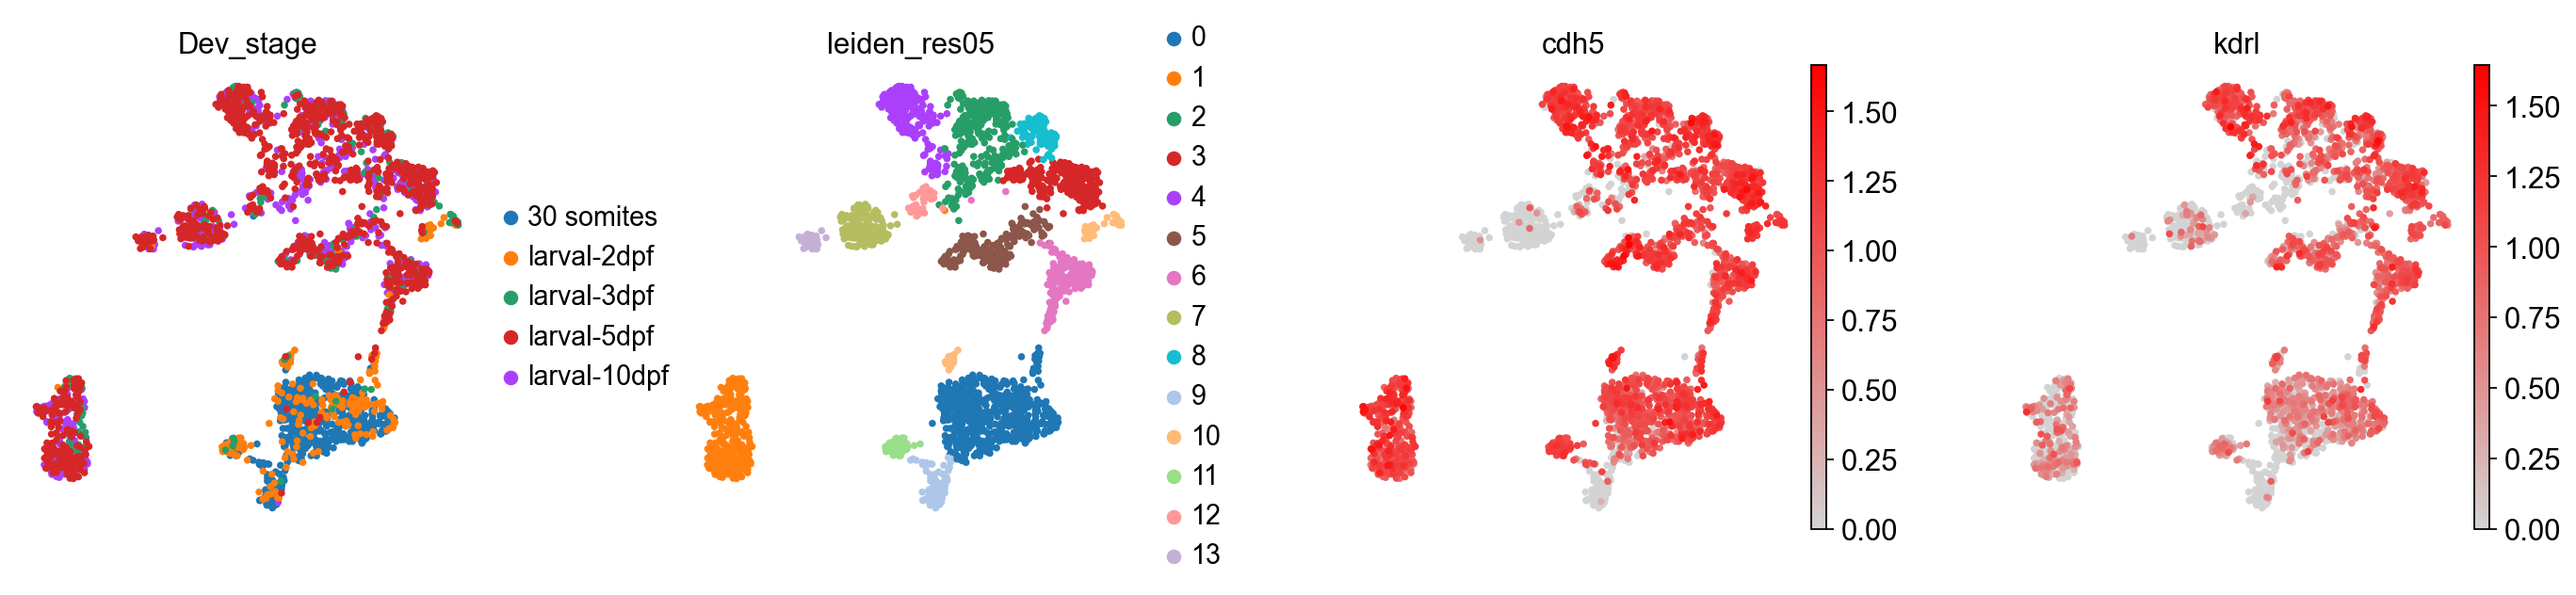

In [5]:
# General UMAP visualisation of endothelial cells
sc.pl.umap(adata, # Anndata containing the single-cell transcriptomic information
           color = ['Dev_stage', 'leiden_res05', 'cdh5', 'kdrl'], 
           # Variables to plot, in this case: i) zebrafish embryo developmental stage, ii) leiden cluster with resolution = 0.5, iii-iv) cdh5 and kdrl endothelial markers stored in adata.var_names
           cmap = cmap, # Define the colormap
           wspace = 0.3 # Define the space between subplots
           )

In [6]:
# Re-label zebrafish embryo developmental stages
adata.obs['Dev_stage'] = adata.obs['Dev_stage'].str.replace('30 somites', '1 dpf')
adata.obs['Dev_stage'] = adata.obs['Dev_stage'].str.replace('larval-10dpf', '10 dpf')
adata.obs['Dev_stage'] = adata.obs['Dev_stage'].str.replace('larval-2dpf', '2 dpf')
adata.obs['Dev_stage'] = adata.obs['Dev_stage'].str.replace('larval-3dpf', '3 dpf')
adata.obs['Dev_stage'] = adata.obs['Dev_stage'].str.replace('larval-5dpf', '5 dpf')

In [7]:
print(adata.uns['Dev_stage_colors'])

['#1f77b4' '#ff7f0e' '#279e68' '#d62728' '#aa40fc']


In [8]:
def UMAP_devstage(adata): # Function to plot individual developmental stages
    
    labels = adata.obs['Dev_stage'].unique()
    # palette = sns.color_palette("tab10", len(labels)) # This will generate a colour palette from matplotlib colours "tab10"
    palette = ['#1f77b4', '#aa40fc', '#ff7f0e', '#279e68', '#d62728'] # Colour palette for each developmental stage to mimic the previous UMAP
    label_to_color = {label: color for label, color in zip(labels, palette)} # Creates a dictionary with each developmetal stage (key) and an associated colour
    other_color = mcolors.to_rgba("lightgray", alpha=0.1) # Light grey colour to plot other non-specified groups
 
    for label in labels:
        # Create a custom color map: red for the current label, white for others
        adata.obs['highlight'] = [
            label if dev_stage == label else "Other"
            for dev_stage in adata.obs['Dev_stage']
        ]

        # Add custom colors to adata.obs
        custom_palette = {"Other": other_color, label: label_to_color[label]}

        # UMAP visualisation of individiual developmental dtages
        sc.pl.umap(
            adata,
            color="highlight",
            title=f'UMAP: {label} highlighted',
            palette=custom_palette,
            show=True,
        )   

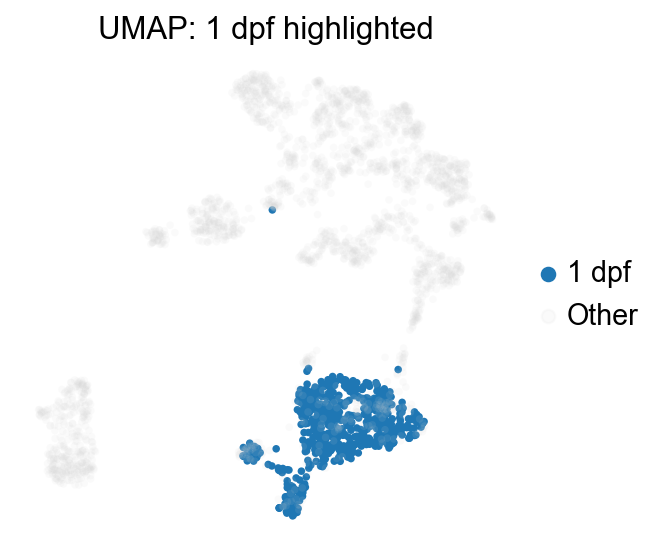

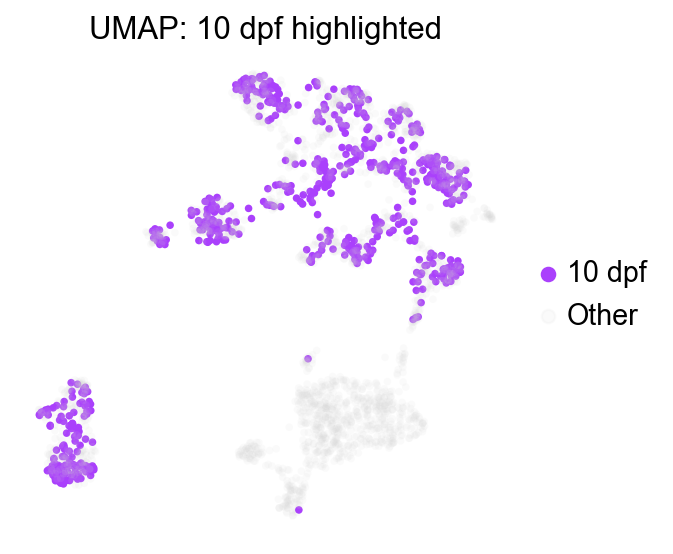

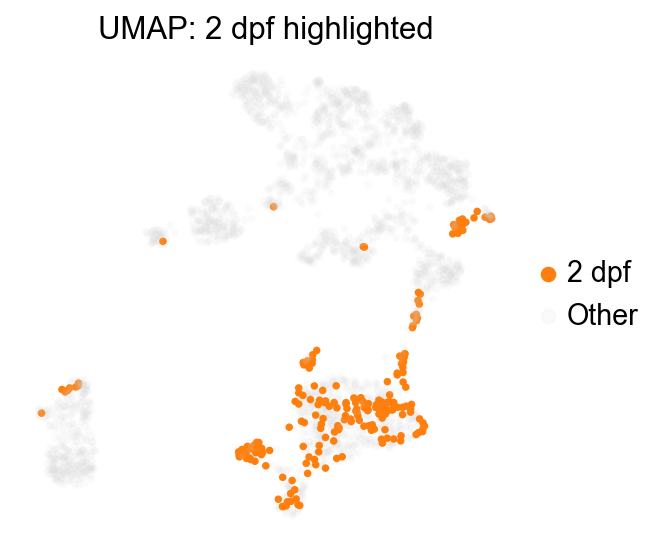

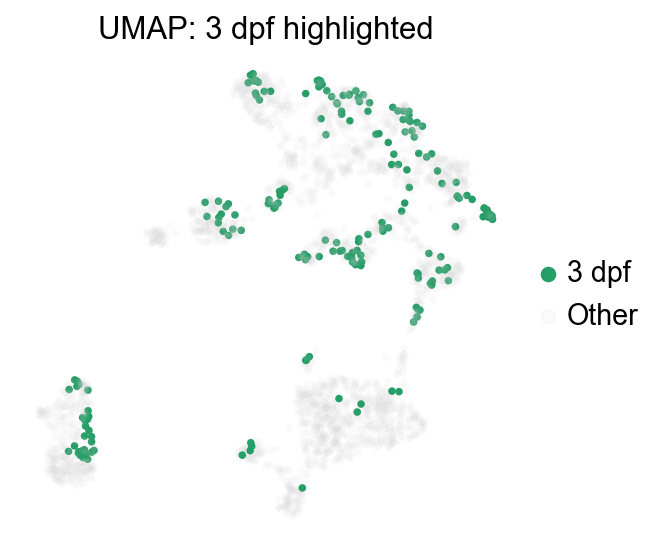

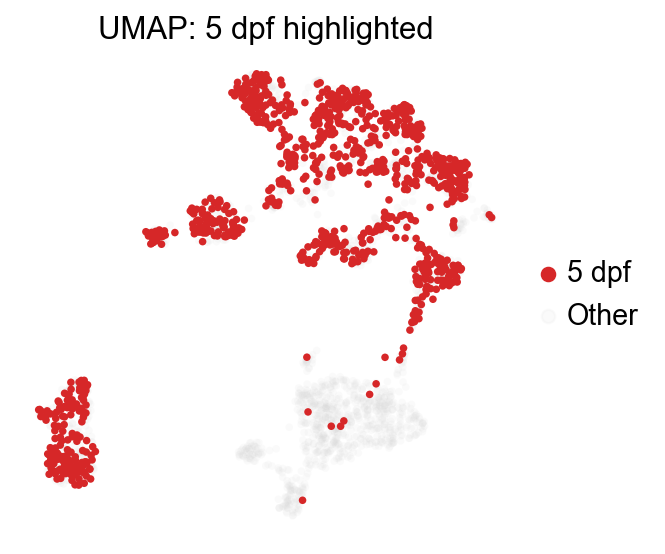

In [9]:
out = UMAP_devstage(adata)

# <a id='toc3_'></a>[Cluster annotation](#toc0_)

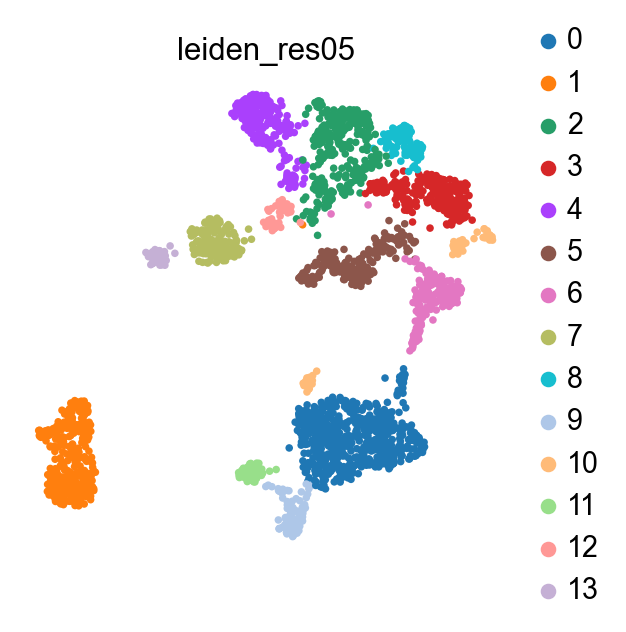

In [10]:
# General UMAP visualisation of endothelial cells
sc.pl.umap(adata, # Anndata containing the single-cell transcriptomic information
           color = ['leiden_res05'], # Leiden cluster with resolution = 0.5
           cmap = cmap, # Define the colormap
           wspace = 0.3 # Define the space between subplots
           )

In [11]:
# Scanpy score function: Average expression of a set of genes subtracted with the average expression of a reference set of genes.
# For additional information please refer to:
    # https://scanpy.readthedocs.io/en/latest/generated/scanpy.tl.score_genes.html

gene_list = ['slc2a1a', 'slco1c1', 'slco1d1', 'slc7a5', 'slc7a3a'] # Blood-brain barrier markers

sc.tl.score_genes(adata,
                  gene_list = gene_list, # List of known targets
                  ctrl_size = 50, # Number of reference genes to be sampled from each bin.
                  gene_pool = None, # Genes for sampling the reference set.
                  n_bins = 25, # Number of expression level bins for sampling.
                  score_name = 'BBB_score', # Label for the score
                  random_state = 0 # Random seed for sampling.                
)

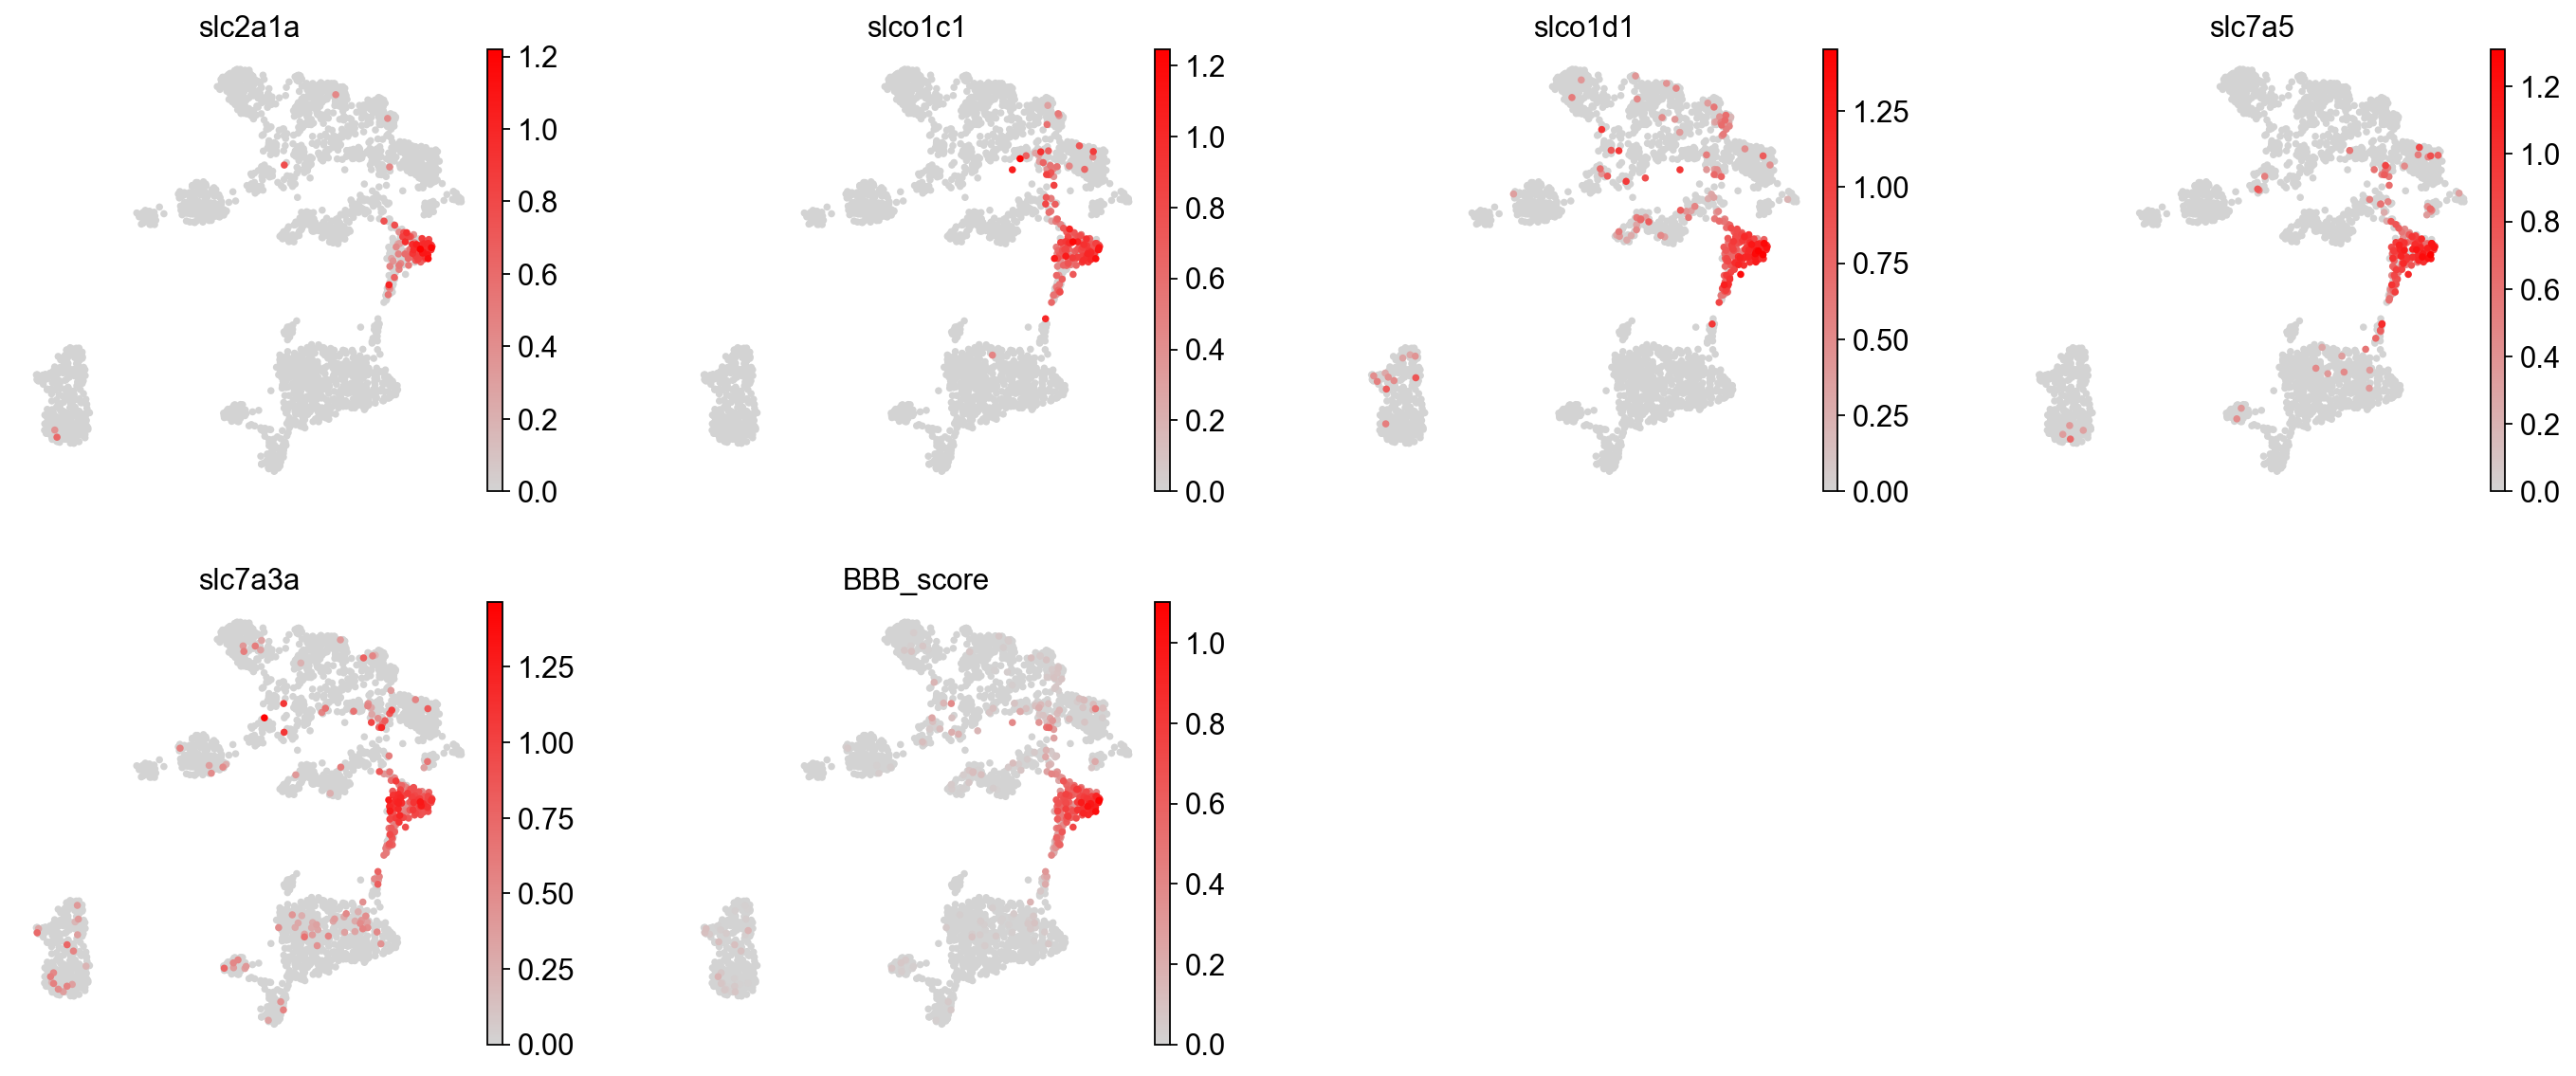

In [12]:
sc.pl.umap(adata, 
           color = ['slc2a1a', 'slco1c1', 'slco1d1', 'slc7a5', 'slc7a3a', 'BBB_score'], # List of known blood-brain barrier targets and BBB_score
           cmap = cmap, # Defined the colormap for visualisation
           vmin = 0.0, # Minimum expression value
           wspace = 0.3, # Define the space between subplots 
           )

In [13]:
lymph_markers = ['prox1a', 'lyve1b', 'stab1', 'flt4'] # Lymphatic markers
sc.tl.score_genes(adata,
                  gene_list = lymph_markers,
                  ctrl_size = 50,
                  gene_pool = None,
                  n_bins = 25,
                  score_name = 'Lymph_score',
                  random_state = 0                
)

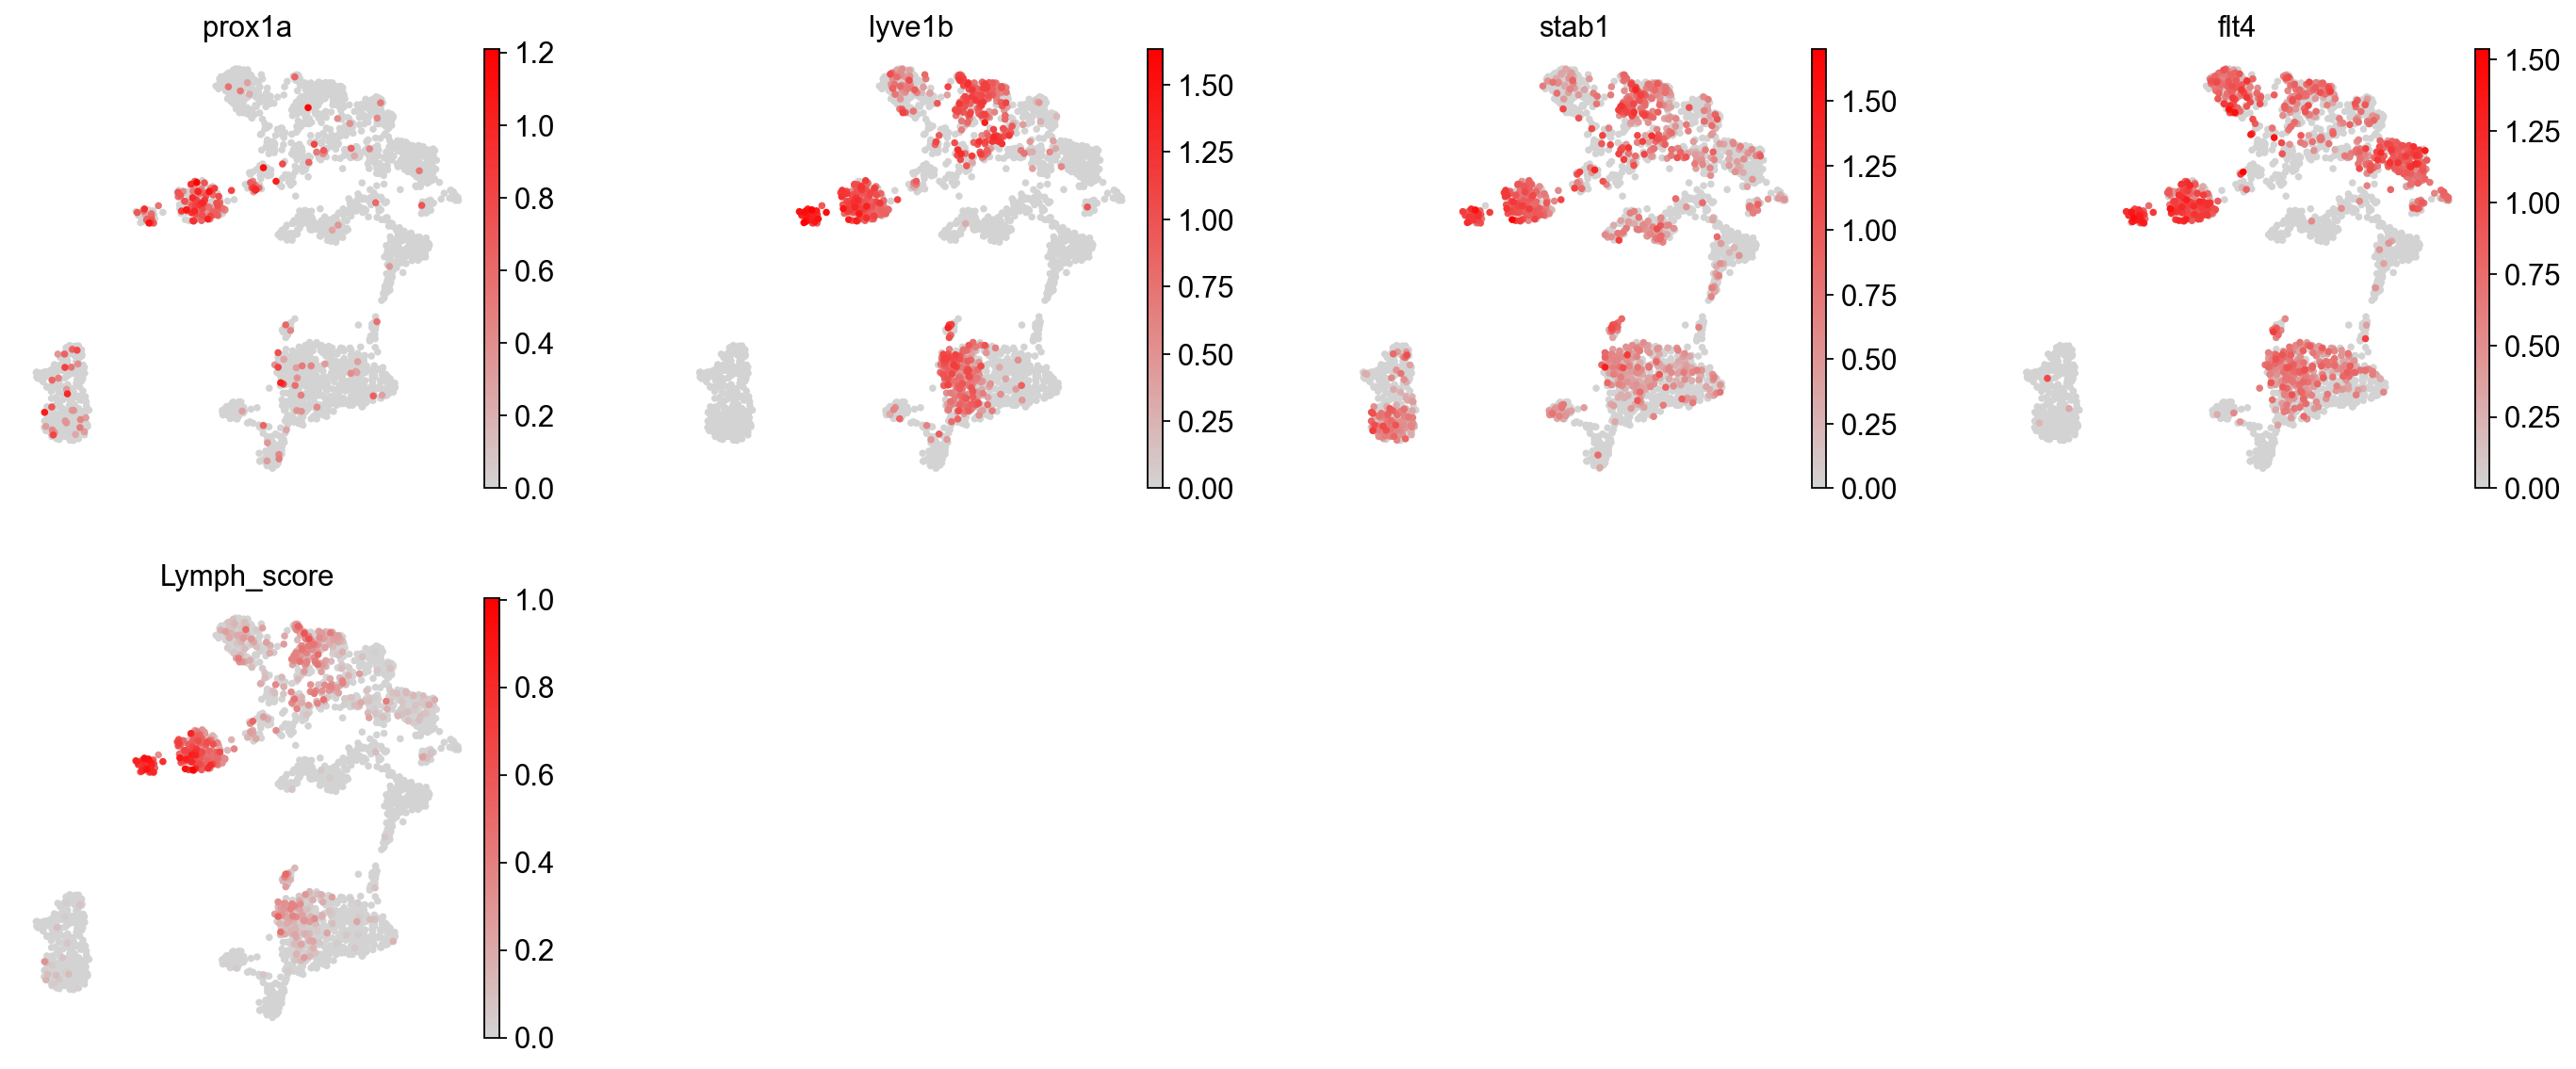

In [14]:
sc.pl.umap(adata, 
           color = ['prox1a', 'lyve1b', 'stab1', 'flt4', 'Lymph_score'], 
           cmap = cmap,
           vmin = 0.0, 
           wspace = 0.3,
           )

In [15]:
gene_list = ['dll4', 'hey2', 'notch3', 'vegfc', 'esm1', 'efnb2b',
             'aqp1a.1', 'sema3ga', 'nrp1b', 'efnb2a'] # Arterial markers
sc.tl.score_genes(adata,
                  gene_list = gene_list,
                  ctrl_size = 50,
                  gene_pool = None,
                  n_bins = 25,
                  score_name = 'Arterial_score',
                  random_state = 0
                  )

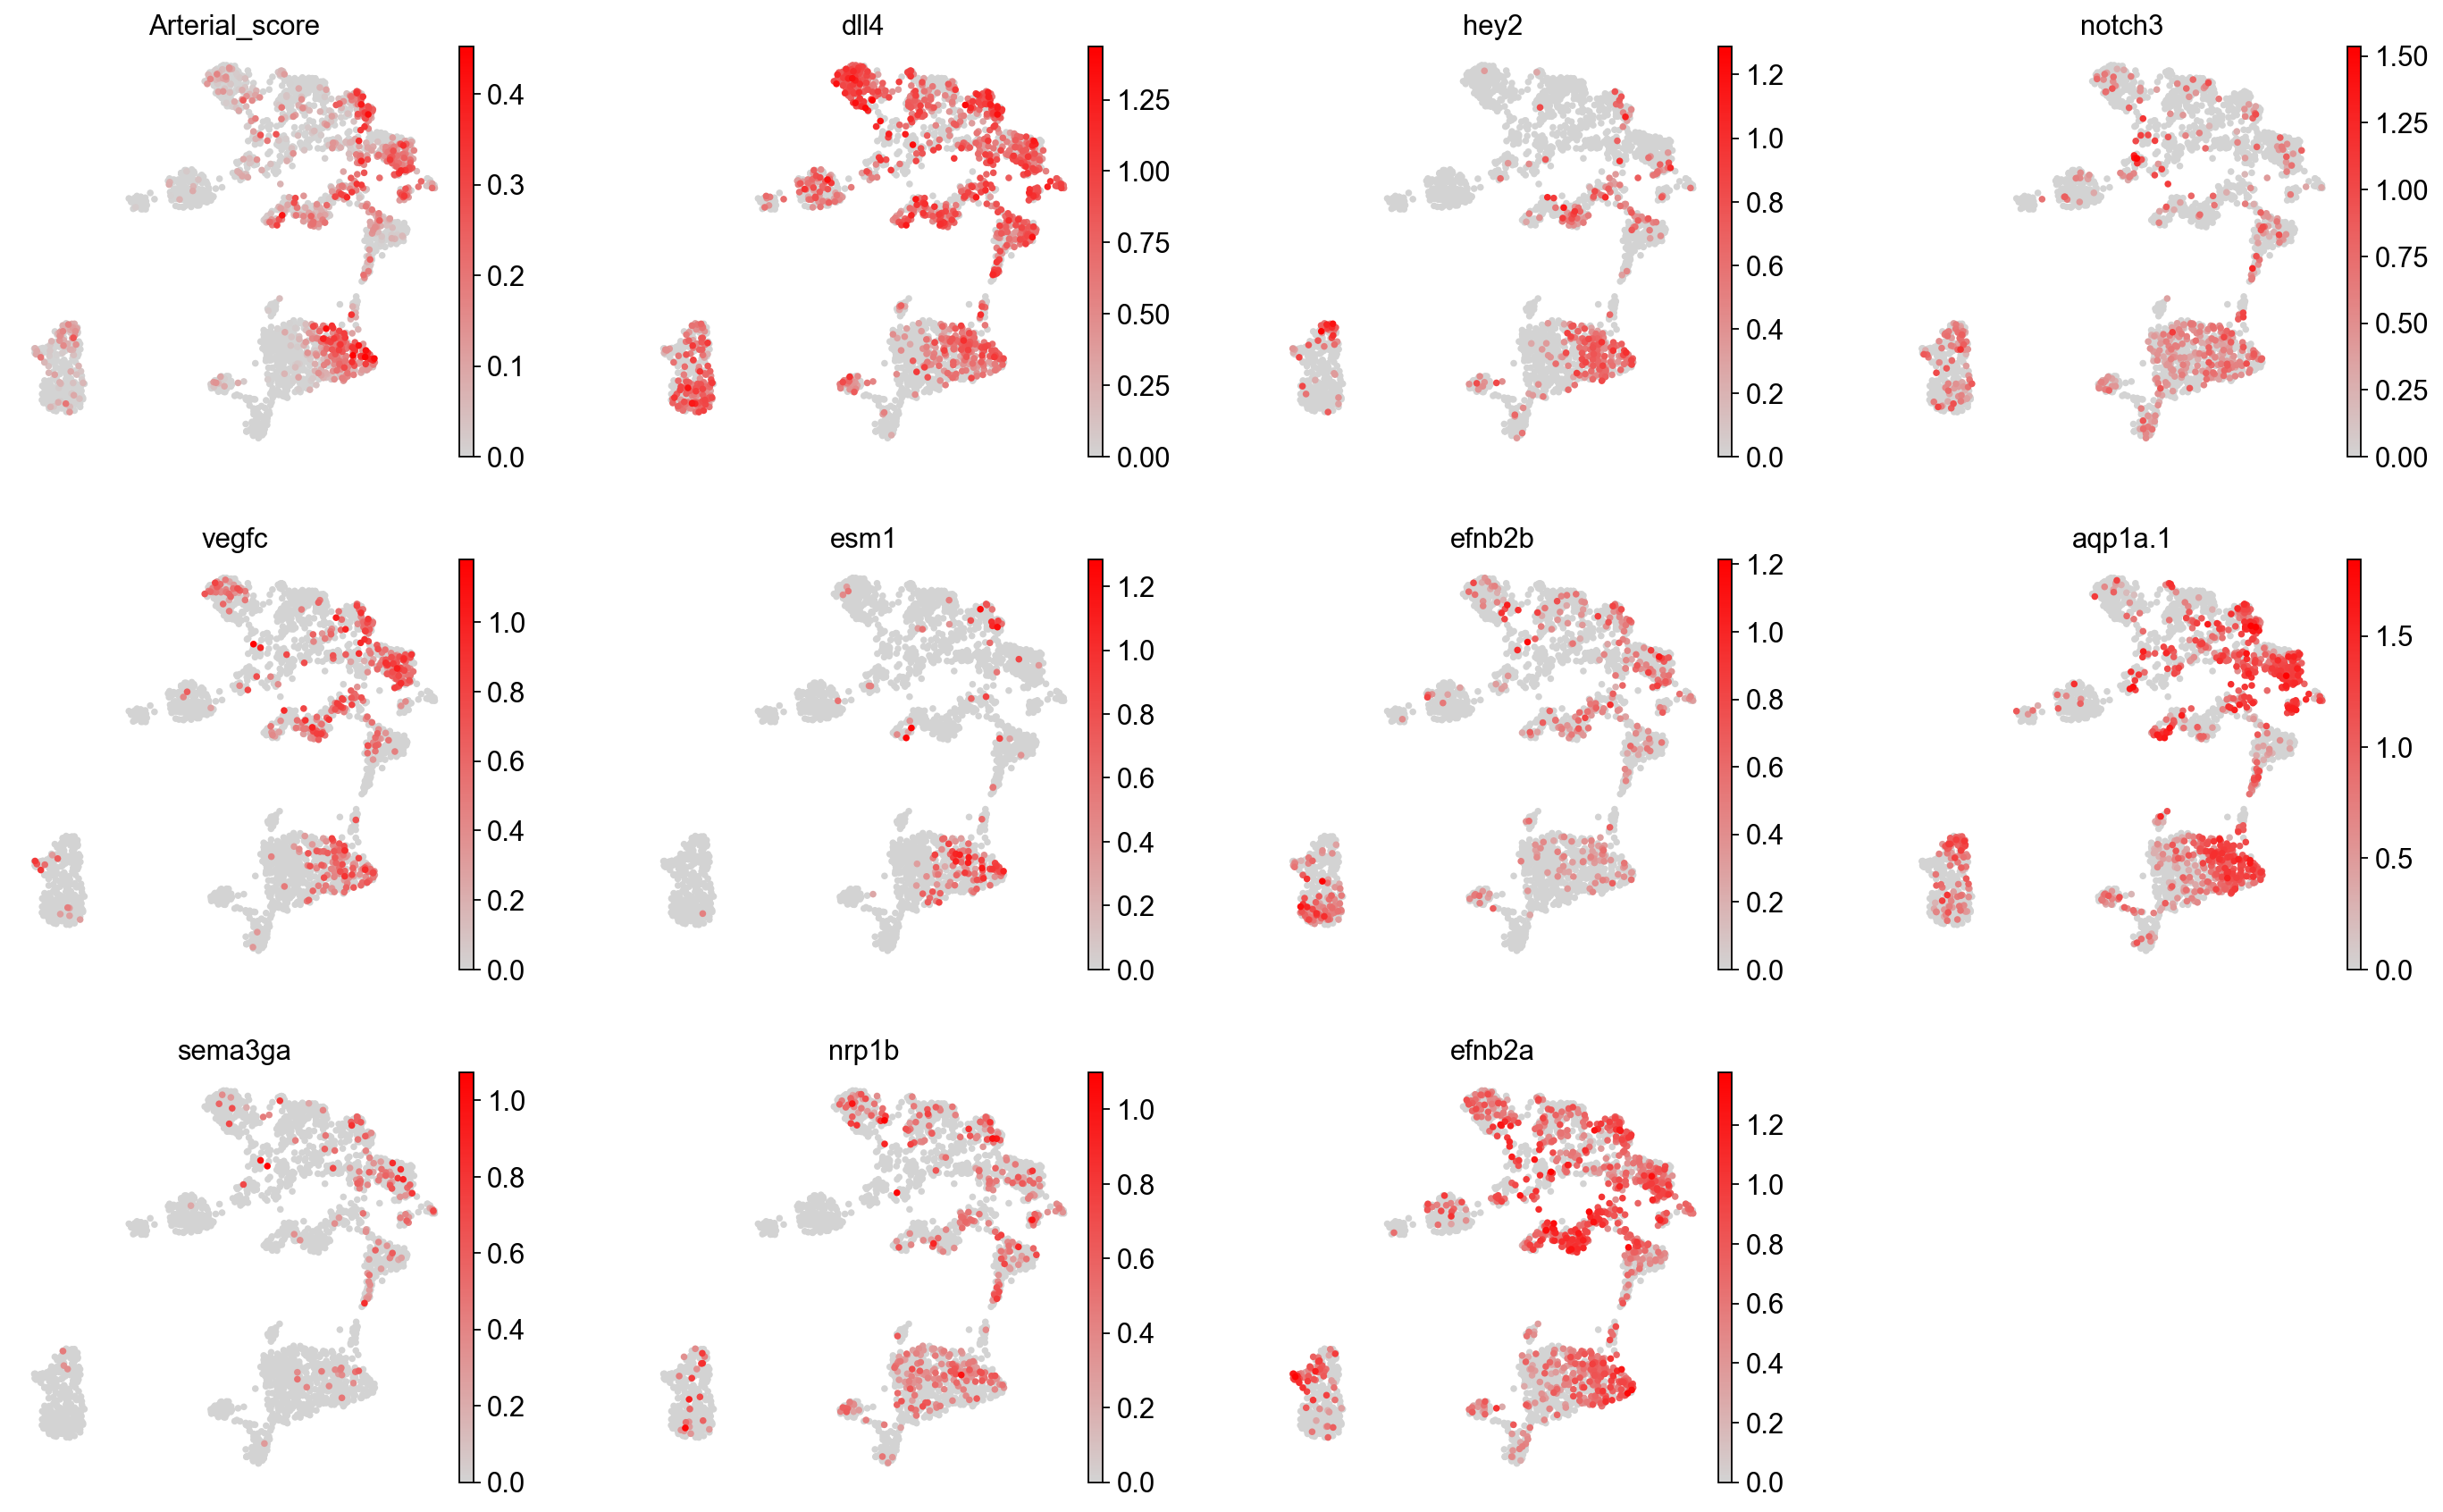

In [16]:
sc.pl.umap(adata, 
           color = ['Arterial_score', 'dll4', 'hey2', 'notch3',
                    'vegfc', 'esm1', 'efnb2b',
                    'aqp1a.1', 'sema3ga', 'nrp1b', 'efnb2a',
                    ],  
           cmap = cmap,
           vmin = 0,
           wspace = 0.3,
           )

In [17]:
gene_list = ['lyve1b', 'stab2', 'mrc1a', 'nrp2b', 
             'dab2', 'mafb', 'nr2f2', 'gpr182'] # Venous markers
sc.tl.score_genes(adata,
                  gene_list = gene_list,
                  ctrl_size = 50,
                  gene_pool = None,
                  n_bins = 25,
                  score_name = 'Vein_score',
                  random_state = 0
                  )

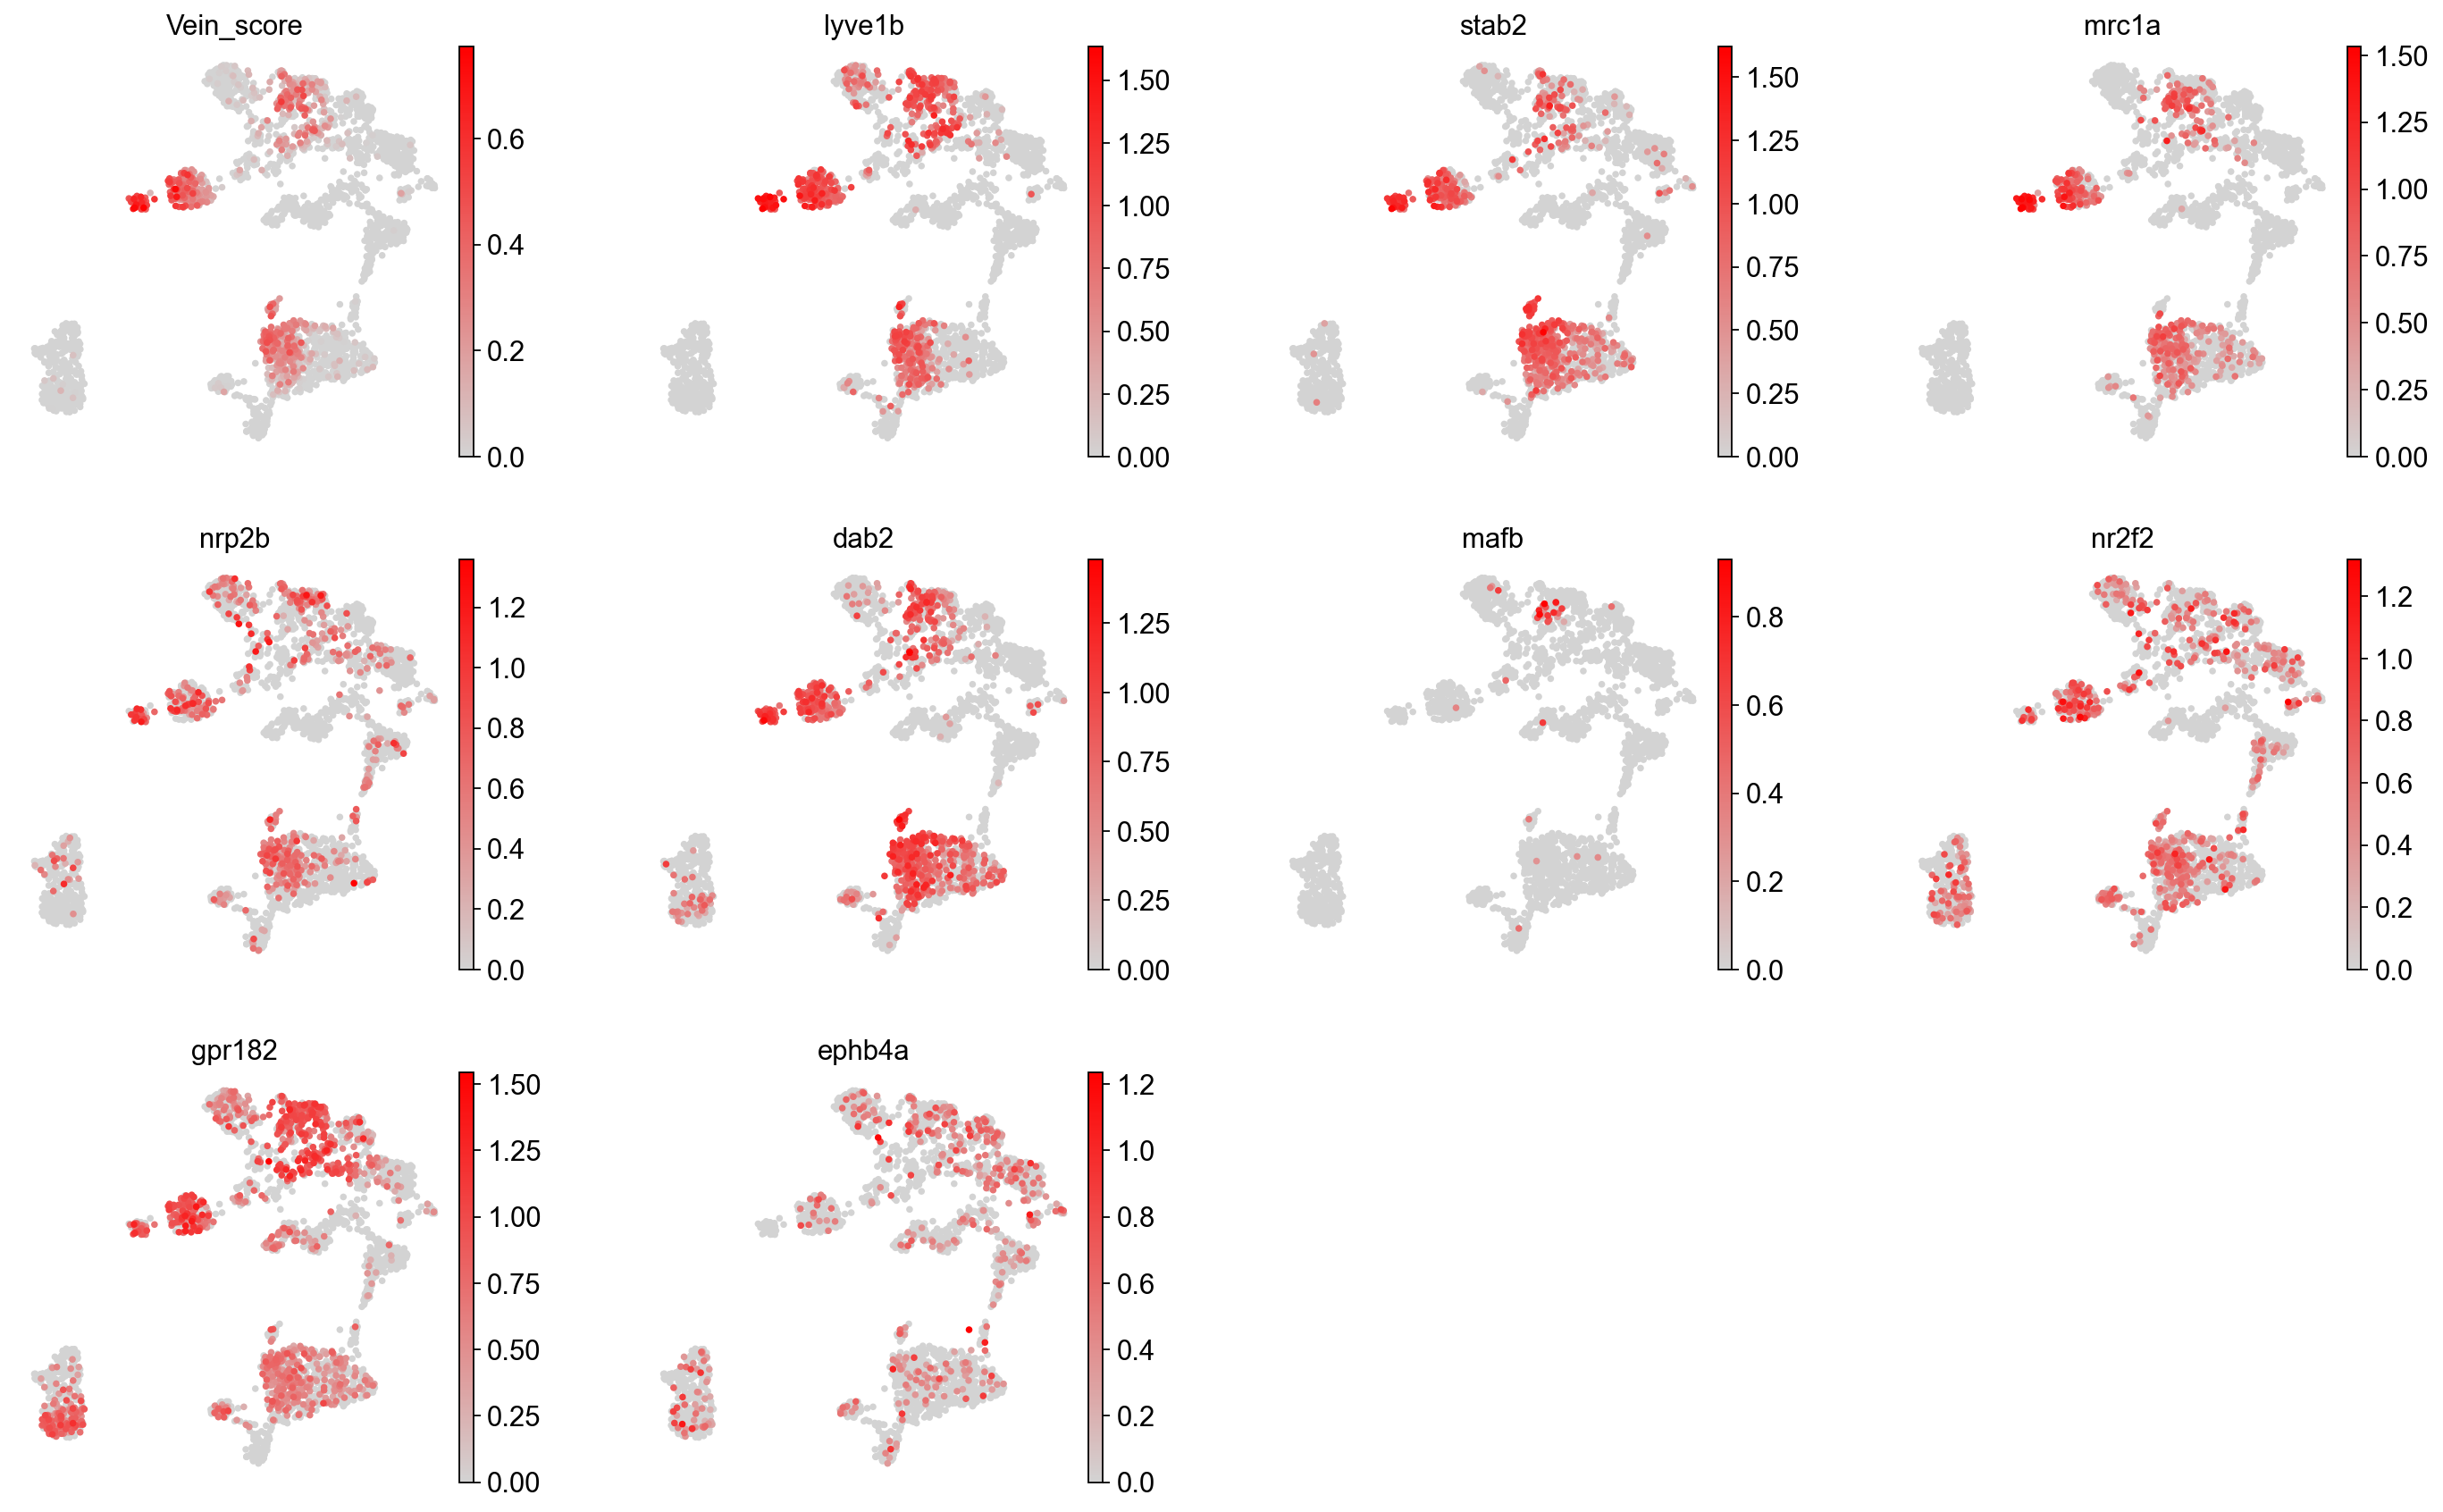

In [18]:
sc.pl.umap(adata, color = ['Vein_score', 'lyve1b', 'stab2', 'mrc1a', 'nrp2b', 
                           'dab2', 'mafb', 'nr2f2', 'gpr182', 'ephb4a'],
           cmap = cmap,
           vmin = 0.0, 
           wspace = 0.3,
           )

In [19]:
gene_list = ['pdgfaa', 'osr2', 'map7d2a', 'gpc1b'] # Brain lymphatic endothelial cell markers
sc.tl.score_genes(adata,
                  gene_list = gene_list,
                  ctrl_size = 50,
                  gene_pool = None,
                  n_bins = 25,
                  score_name = 'BLEC_score',
                  random_state = 0                
)

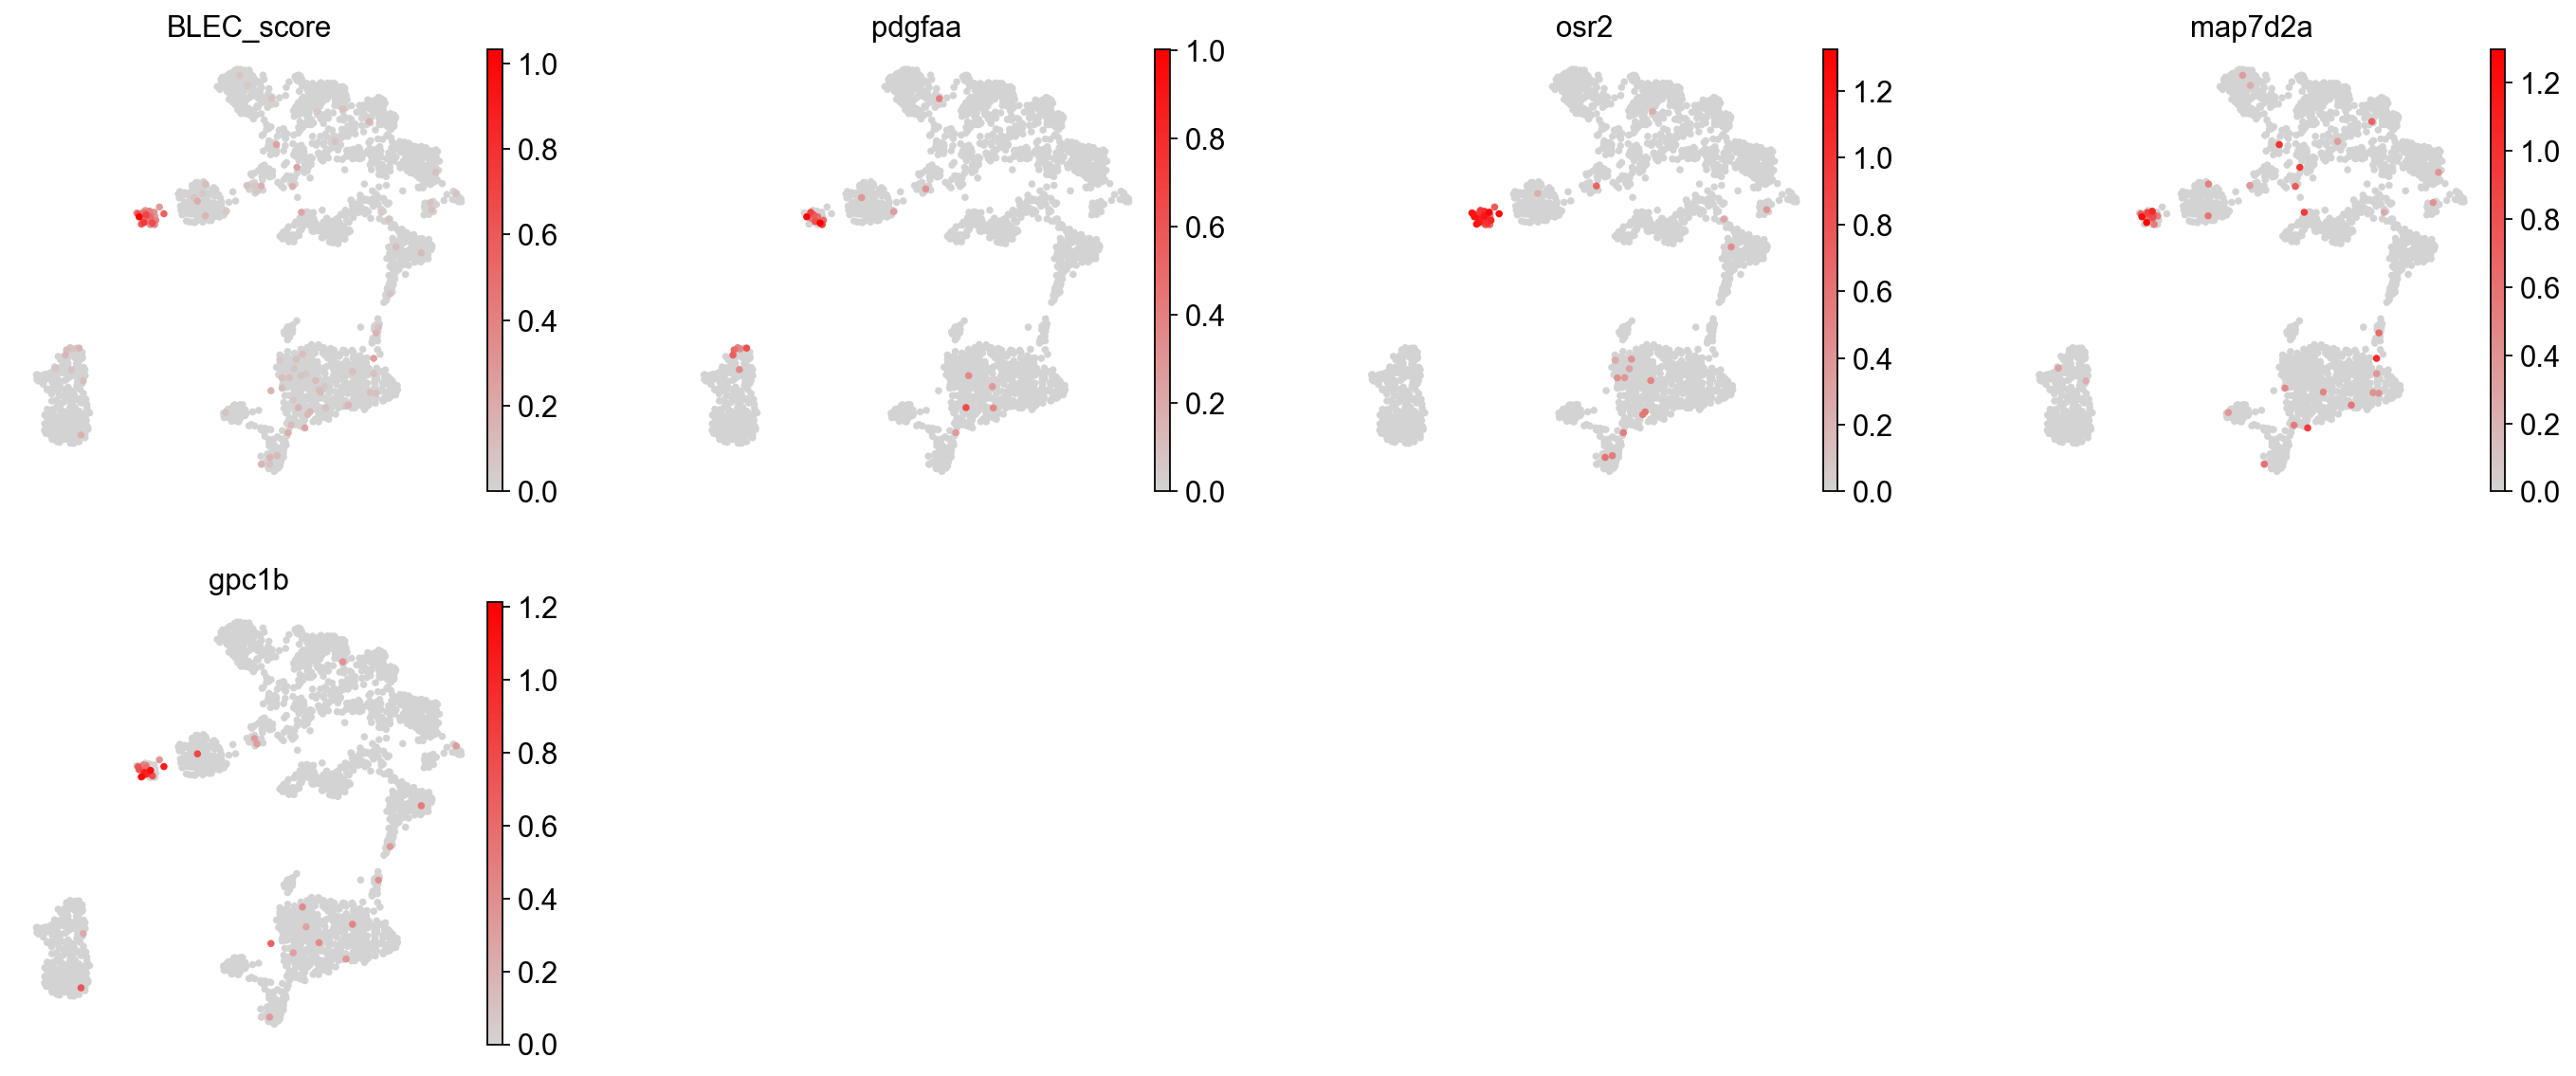

In [20]:
sc.pl.umap(adata, 
           color = ['BLEC_score', 'pdgfaa', 
                    'osr2', 'map7d2a', 'gpc1b'],
           cmap = cmap,
           vmin = 0.0, 
           wspace = 0.3,
)

In [21]:
# Scanpy cluster markers function: Rank genes for characterising groups.
# For additional information please refer to:
    # https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.rank_genes_groups.html

sc.tl.rank_genes_groups(adata, 
                        groupby="leiden_res05", # Label in adata.obs to explore the ranked genes
                        method="wilcoxon", # Method to analyse the significance of each gene. In this case Wilcoxon rank-sum
                        key_added="rnk_genes_leiden_res05", # Label added to adata to retrieve the rank information
                        corr_method = 'benjamini-hochberg' # p-value correction method. In this case, BH-FDR
                        )

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [22]:
# Scanpy filtering markers function: Filters out genes based on log fold change and fraction of genes expressing the gene within and outside the groupby categories.
# For additional information please refer to:
    # https://scanpy.readthedocs.io/en/1.10.x/generated/scanpy.tl.filter_rank_genes_groups.html
    
sc.tl.filter_rank_genes_groups(adata, # Input anndata object
                               min_in_group_fraction=0.1, # Define the minimum percentage of cells within the group that need to present the marker
                               max_out_group_fraction=0.01, # Define the maximum percentage of cells outside of a particular group that need to present the marker
                               key="rnk_genes_leiden_res05", # This variable needs to be the same key_added as the one used during sc.tl.rank_genes_groups
                               key_added="rnk_genes_leiden_res05_filtered", # Add a new key to store the data
)

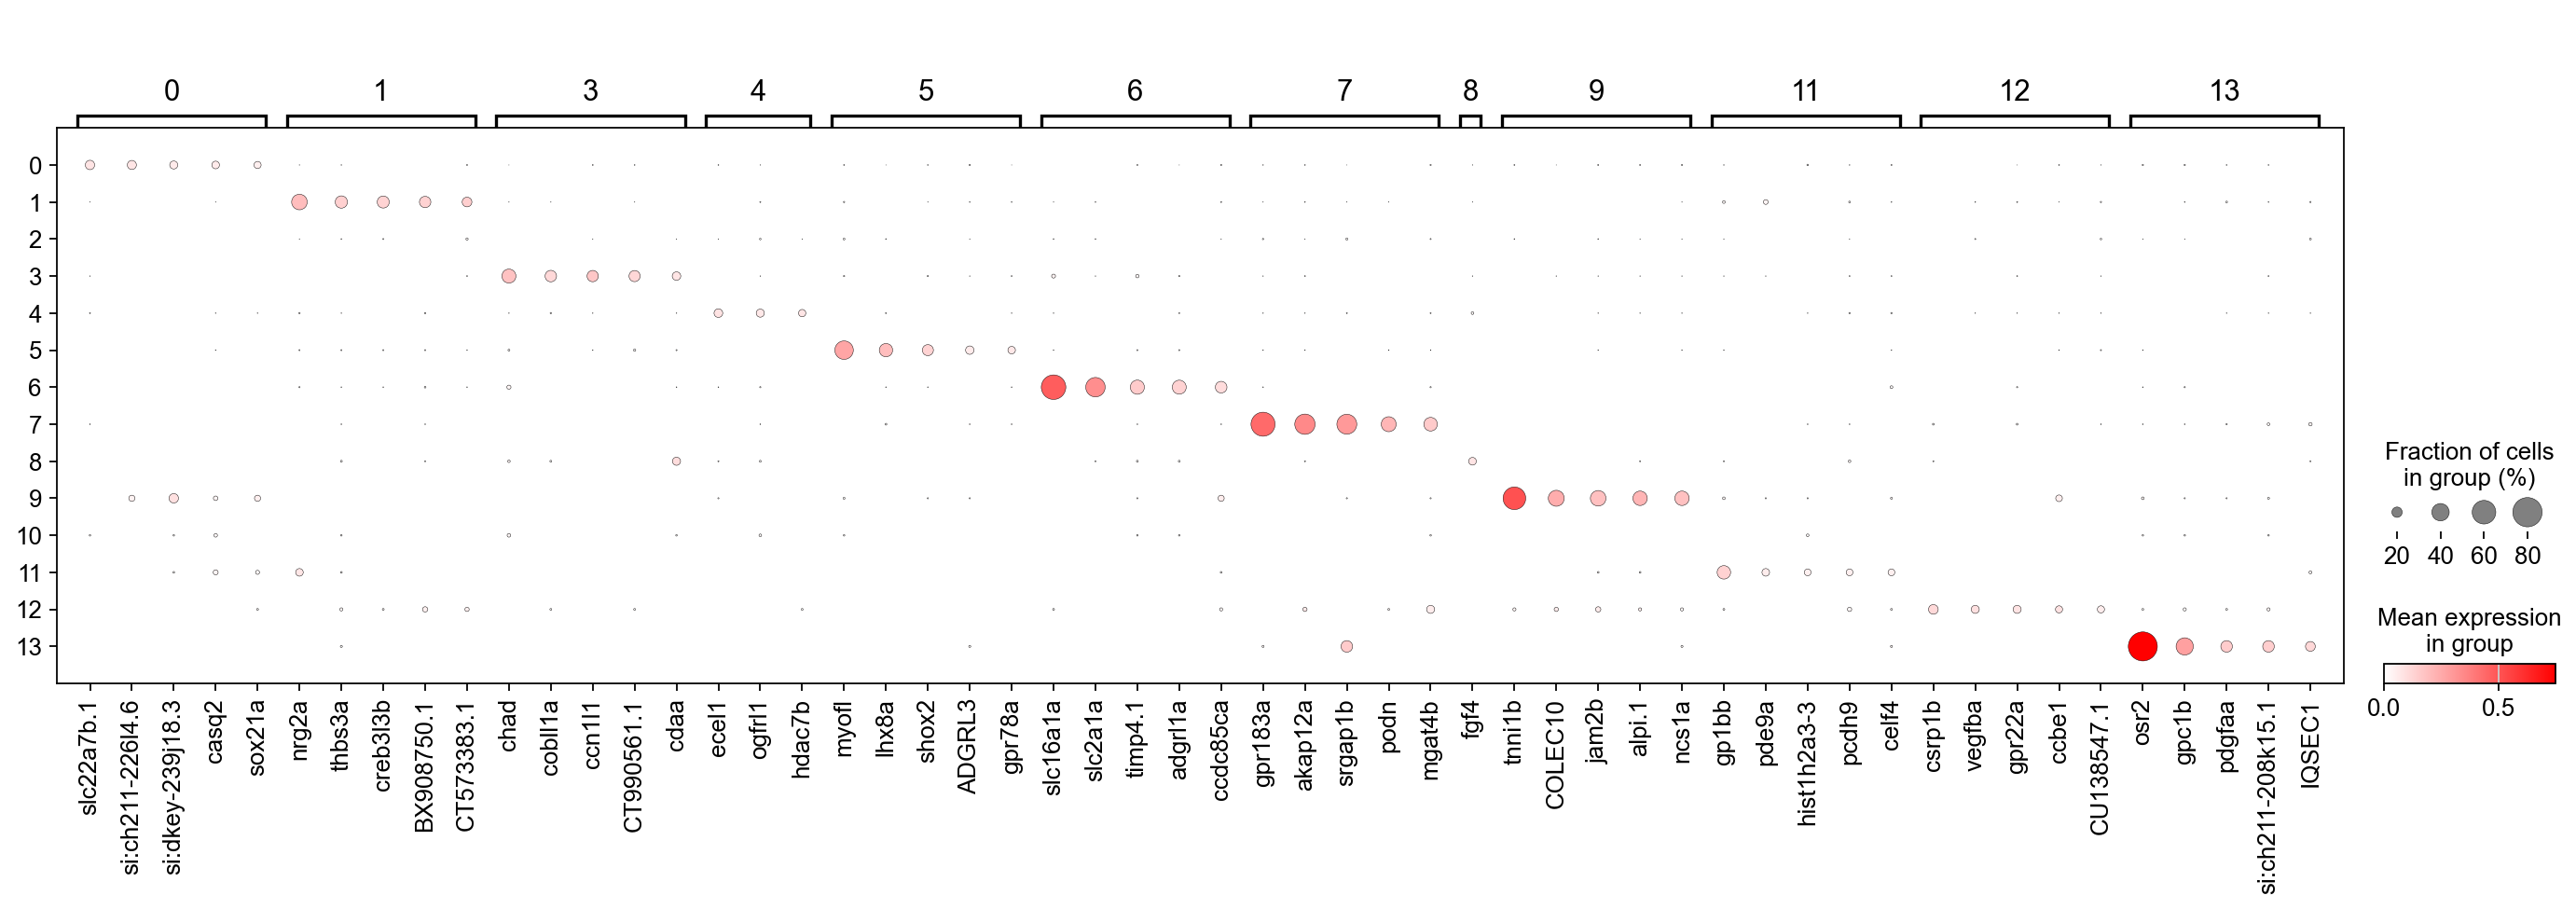

In [23]:
# For additional information please refer to:
    # https://scanpy.readthedocs.io/en/stable/api/generated/scanpy.pl.rank_genes_groups_dotplot.html
    # https://scanpy.readthedocs.io/en/stable/generated/scanpy.pl.dotplot.html#scanpy.pl.dotplot
# Plot the top most differentially expressed markers from each leiden cluster

sc.pl.rank_genes_groups_dotplot(adata, 
                                groupby="leiden_res05", # This variable needs to be the same group as the one used during sc.tl.rank_genes_groups
                                use_raw = True, # Use the original raw expression values stored in adata
                                mean_only_expressed = False, # Account for the expression of all cells within the cluster
                                smallest_dot = 0, # Define the size of the smallest dot. Setting this to '0' will allow to identify cell cluster not expressing the marker.
                                n_genes=5, # Number of genes in each cluster to be plotted
                                key="rnk_genes_leiden_res05_filtered", # Add a new key to store the data
                                cmap = cmap2, # Define the colormap
                                dendrogram = False, # Remove the dendogram to have clusters ordered in ascending values.
                                # If dendogram = True, a dendrogram based on the hierarchical clustering between the groupby categories is added. 
                                # The dendrogram information is computed using scanpy.tl.dendrogram(). https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.dendrogram.html#scanpy.tl.dendrogram
)

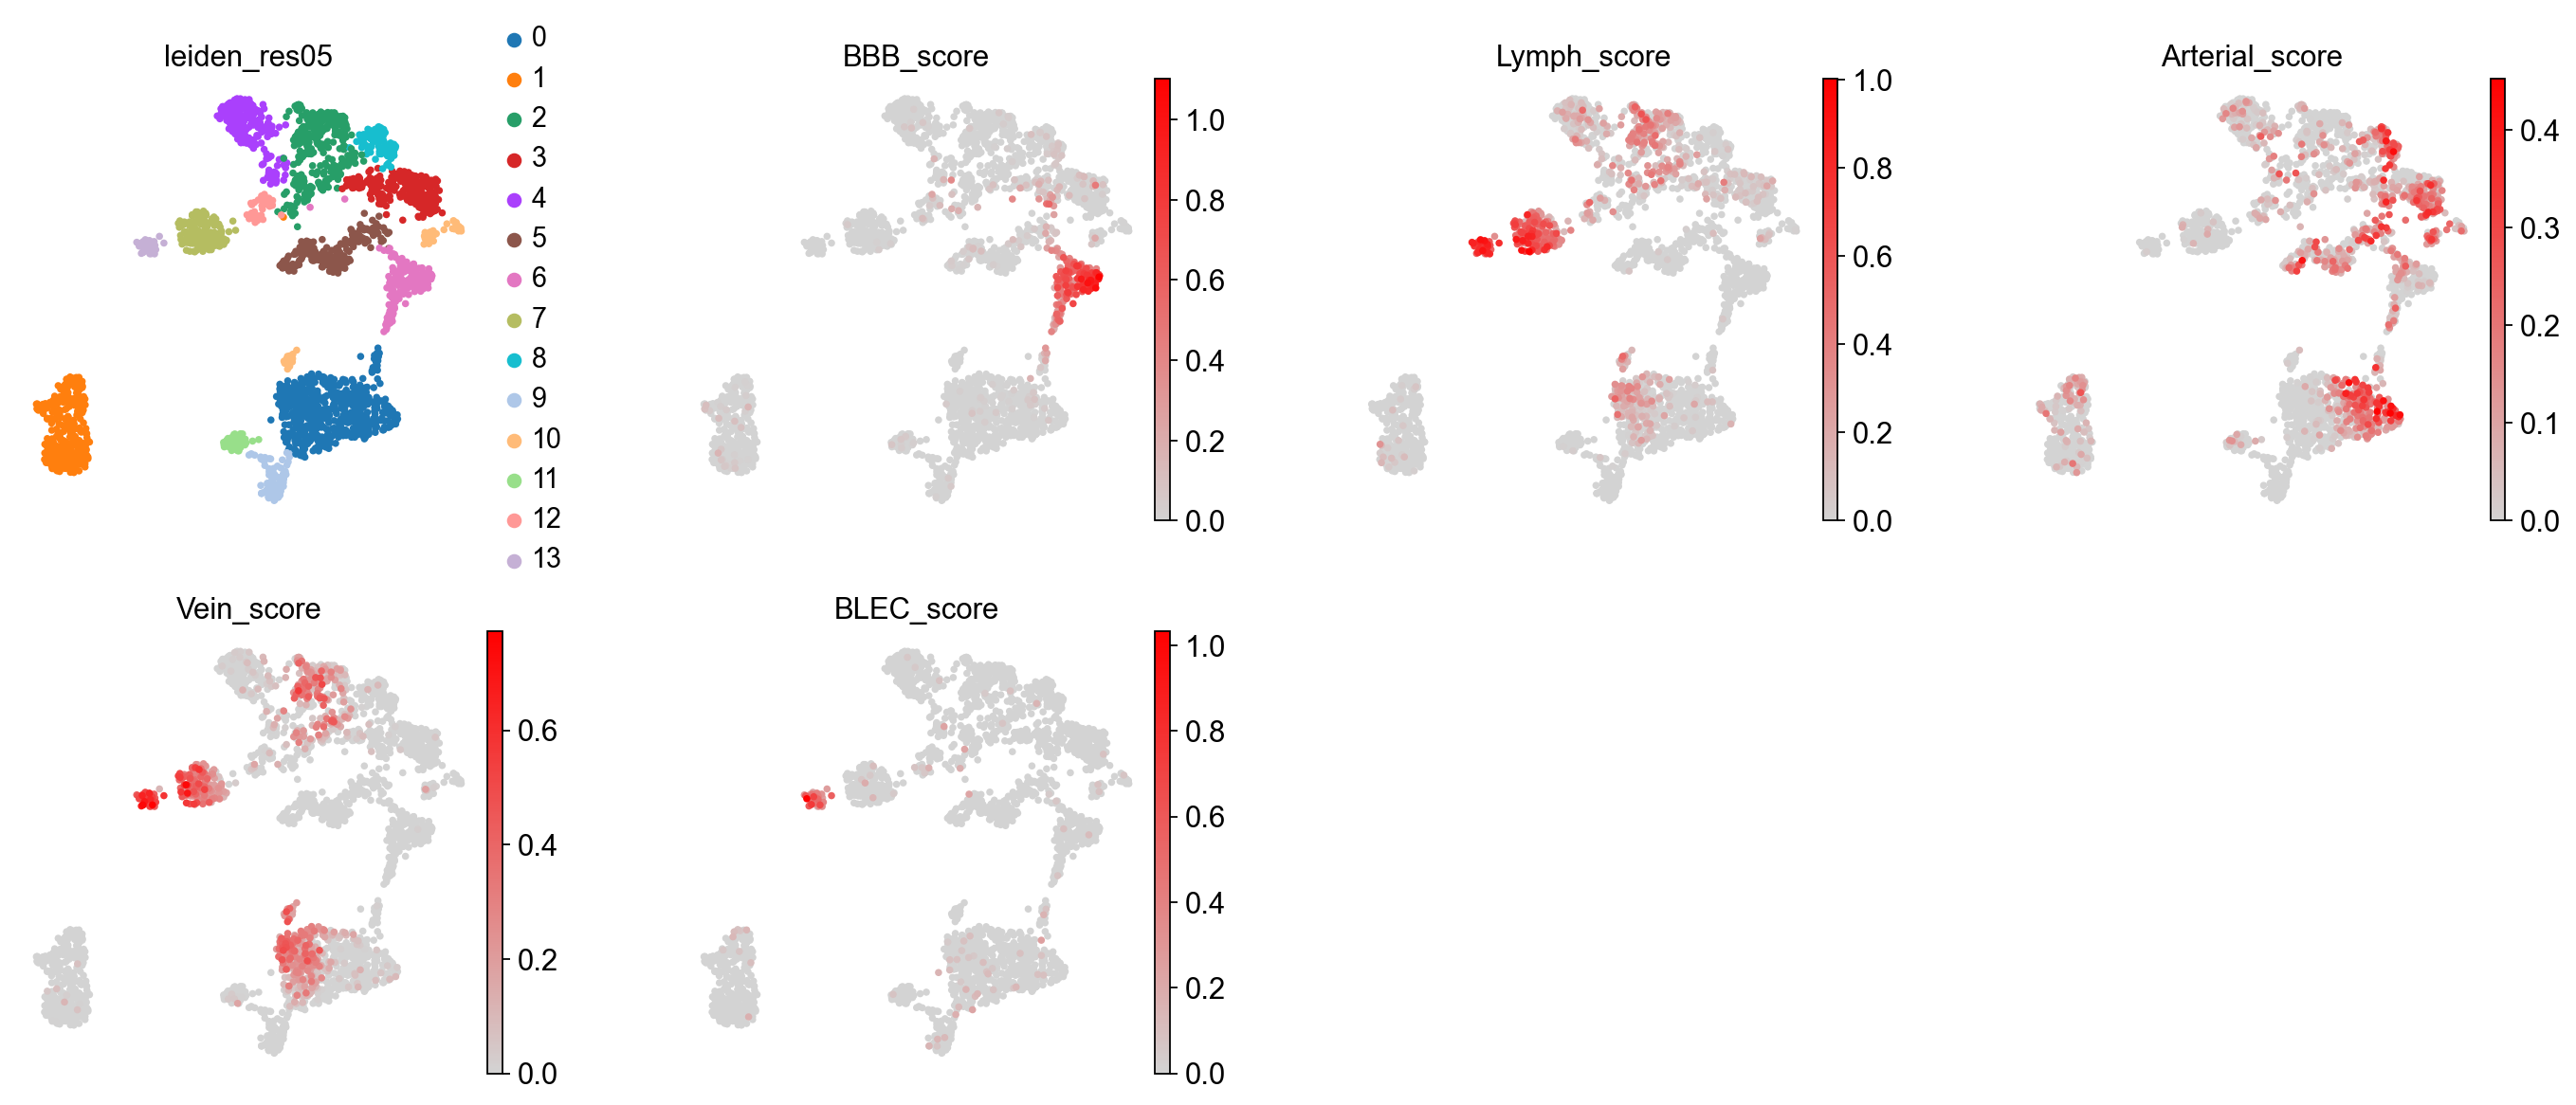

In [24]:
sc.pl.umap(adata, 
           color=['leiden_res05', 'BBB_score', 'Lymph_score', 'Arterial_score', 'Vein_score', 'BLEC_score'], 
           cmap = cmap,
           vmin = 0, 
           wspace = 0.3
)

In [25]:
# Manual annotation of endothelial cell clusters
cluster_mapping = {
    "4": "Venous",
    "10": "Venous",
    "0": "Venous",
    "11": "Arterial",
    "1": "Arterial",
    "15": "Arterial",
    "14": "Arterial",
    "8": "Arterial",
    "2": "Arterial",
    "6": "Blood-brain barrier",
    "7": "Lymphatics",
    "17": "BLEC",
}
adata.obs['cluster_labels'] = adata.obs['leiden_res1'].map(cluster_mapping)
adata.obs['cluster_labels'] = adata.obs['cluster_labels'].fillna("Others")

In [26]:
adata.obs['cluster_labels'].value_counts() # Count the number of cells in each cluster

cluster_labels
Arterial               839
Others                 726
Venous                 664
Blood-brain barrier    163
Lymphatics             153
BLEC                    43
Name: count, dtype: int64

In [27]:
# Define a dictionary with a colour palette to plot the new cluster annotations
custom_palette = {
    "Venous": "cornflowerblue",
    "Arterial": "brown",
    "Lymphatics": "forestgreen",
    "Blood-brain barrier": "goldenrod",
    "BLEC": "indigo",
    "Others": (0.5, 0.5, 0.5, 0.2)  # RGBA values for gray with 0.2 opacity
}

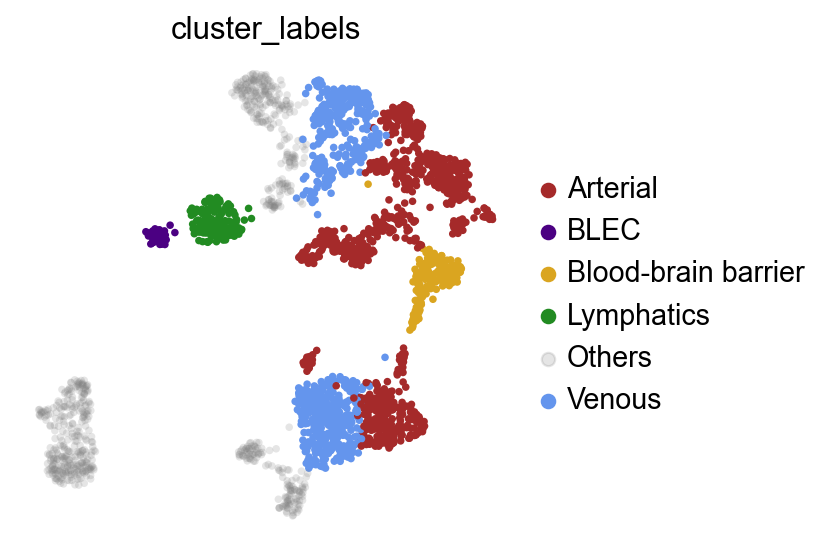

In [28]:
sc.pl.umap(adata, 
           color=['cluster_labels'], 
           palette=custom_palette,
           vmin = 0,
           wspace = 0.3,
)

# <a id='toc4_'></a>[Data visualisation 1 -  Expression of defined targets](#toc0_)

In [29]:
# Remove the 'unknown' cell clusters if needed for further analysis
known_clusters = ['Venous', 'Arterial', 'Lymphatics', 'Blood-brain barrier', 'BLEC']
bdata = adata[adata.obs['cluster_labels'].isin(known_clusters)].copy() # Store the adata information into a new variable called bdata, presenting only the information from annotated cluster
bdata

AnnData object with n_obs × n_vars = 1862 × 19559
    obs: 'Sample', 'Dev_stage', 'EC_score', 'leiden_res05', 'leiden_res1', 'leiden_res15', 'Lymph_score', 'highlight', 'BBB_score', 'Arterial_score', 'Vein_score', 'BLEC_score', 'cluster_labels'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Dev_stage_colors', 'hvg', 'leiden', 'leiden_res05_colors', 'leiden_res15_colors', 'leiden_res1_colors', 'log1p', 'neighbors', 'pca', 'umap', 'highlight_colors', 'rnk_genes_leiden_res05', 'rnk_genes_leiden_res05_filtered', 'cluster_labels_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [30]:
bdata.obs['cluster_labels'].value_counts() # Count the number of cells in each cluster

cluster_labels
Arterial               839
Venous                 664
Blood-brain barrier    163
Lymphatics             153
BLEC                    43
Name: count, dtype: int64

In [31]:
bdata.layers['counts'] = bdata.X.copy() # Store the original counts stored in anndata.X into a new layer named as mtx_data.layers['counts'] to prevent loosing data
sc.pp.normalize_total(bdata) # Normalise the anndata object
sc.pp.log1p(bdata) # Logarithmise the data matrix.

In [32]:
# Define the list of targets to analyse
genes = ['lyve1b', 'notch1b', 'cdh5', 'slc2a1a',]

In [33]:
# Separate each zebrafish developmental stage within a cluster
bdata.obs['celltype_Dev_stage'] = bdata.obs['cluster_labels'].astype(str) + '_' + bdata.obs['Dev_stage'].astype(str)

In [34]:
# Matrix plot with mean expression
gene_box_plot_list = ['lyve1b', 'notch1b', 'cdh5', 'slc2a1a',]

# Initialise dictionaries to store results
means_dict = {}
medians_dict = {}

# Process each gene
for gene_box_plot in gene_box_plot_list:
    
    # Step 1: Create combined_data for the current gene
    dfs = []
    for i in bdata.obs['celltype_Dev_stage'].unique(): # Change to the bdata.obs variable to be grouped by, for example: 'cluster_labels'
        subset = bdata[bdata.obs['celltype_Dev_stage'] == i] # Subset bdata based on the previous defined category
        exp = pd.DataFrame(subset.raw[:, gene_box_plot].X.todense()) # Obtain the raw counts for each gene of interest
        exp.rename(columns={0: i}, inplace=True)
        dfs.append(exp)
    
    # Dataframe processing
    long_format = []
    for idx, df in enumerate(dfs):
        melted = df.melt(var_name='Column', value_name='Value')
        melted['Source'] = f'Dataframe_{idx + 1}'
        long_format.append(melted)
    combined_data = pd.concat(long_format, ignore_index=True)
    combined_data.sort_values('Column', ascending=True, inplace=True)
    
    # Step 2: Calculate mean and median for each category
    stats = combined_data.groupby('Column')['Value'].agg(['mean', 'median'])
    
    # Step 3: Store results in dictionaries
    means_dict[gene_box_plot] = stats['mean']
    medians_dict[gene_box_plot] = stats['median']

# Step 4: Combine results into DataFrames
df_means = pd.DataFrame(means_dict)
df_medians = pd.DataFrame(medians_dict)

df_means['Column_name'] = df_means.index
df_means['Stage'] = df_means['Column_name'].apply(
    lambda x: re.search(r'\d+ dpf', x).group() if re.search(r'\d+ dpf', x) else None
)
stage_order = ['1 dpf', '2 dpf', '3 dpf', '5 dpf', '10 dpf'] # Define the order to the zebrafish developmental stage to be used in subsequent plotting
stage_type = CategoricalDtype(categories=stage_order, ordered=True)
df_means['Stage'] = df_means['Stage'].astype(stage_type)
df_means.sort_values(['Stage', 'Column_name'], ascending=[True, True], inplace = True)
order = df_means['Column_name'].tolist()
df_means.drop(['Stage', 'Column_name'], axis=1, inplace=True)

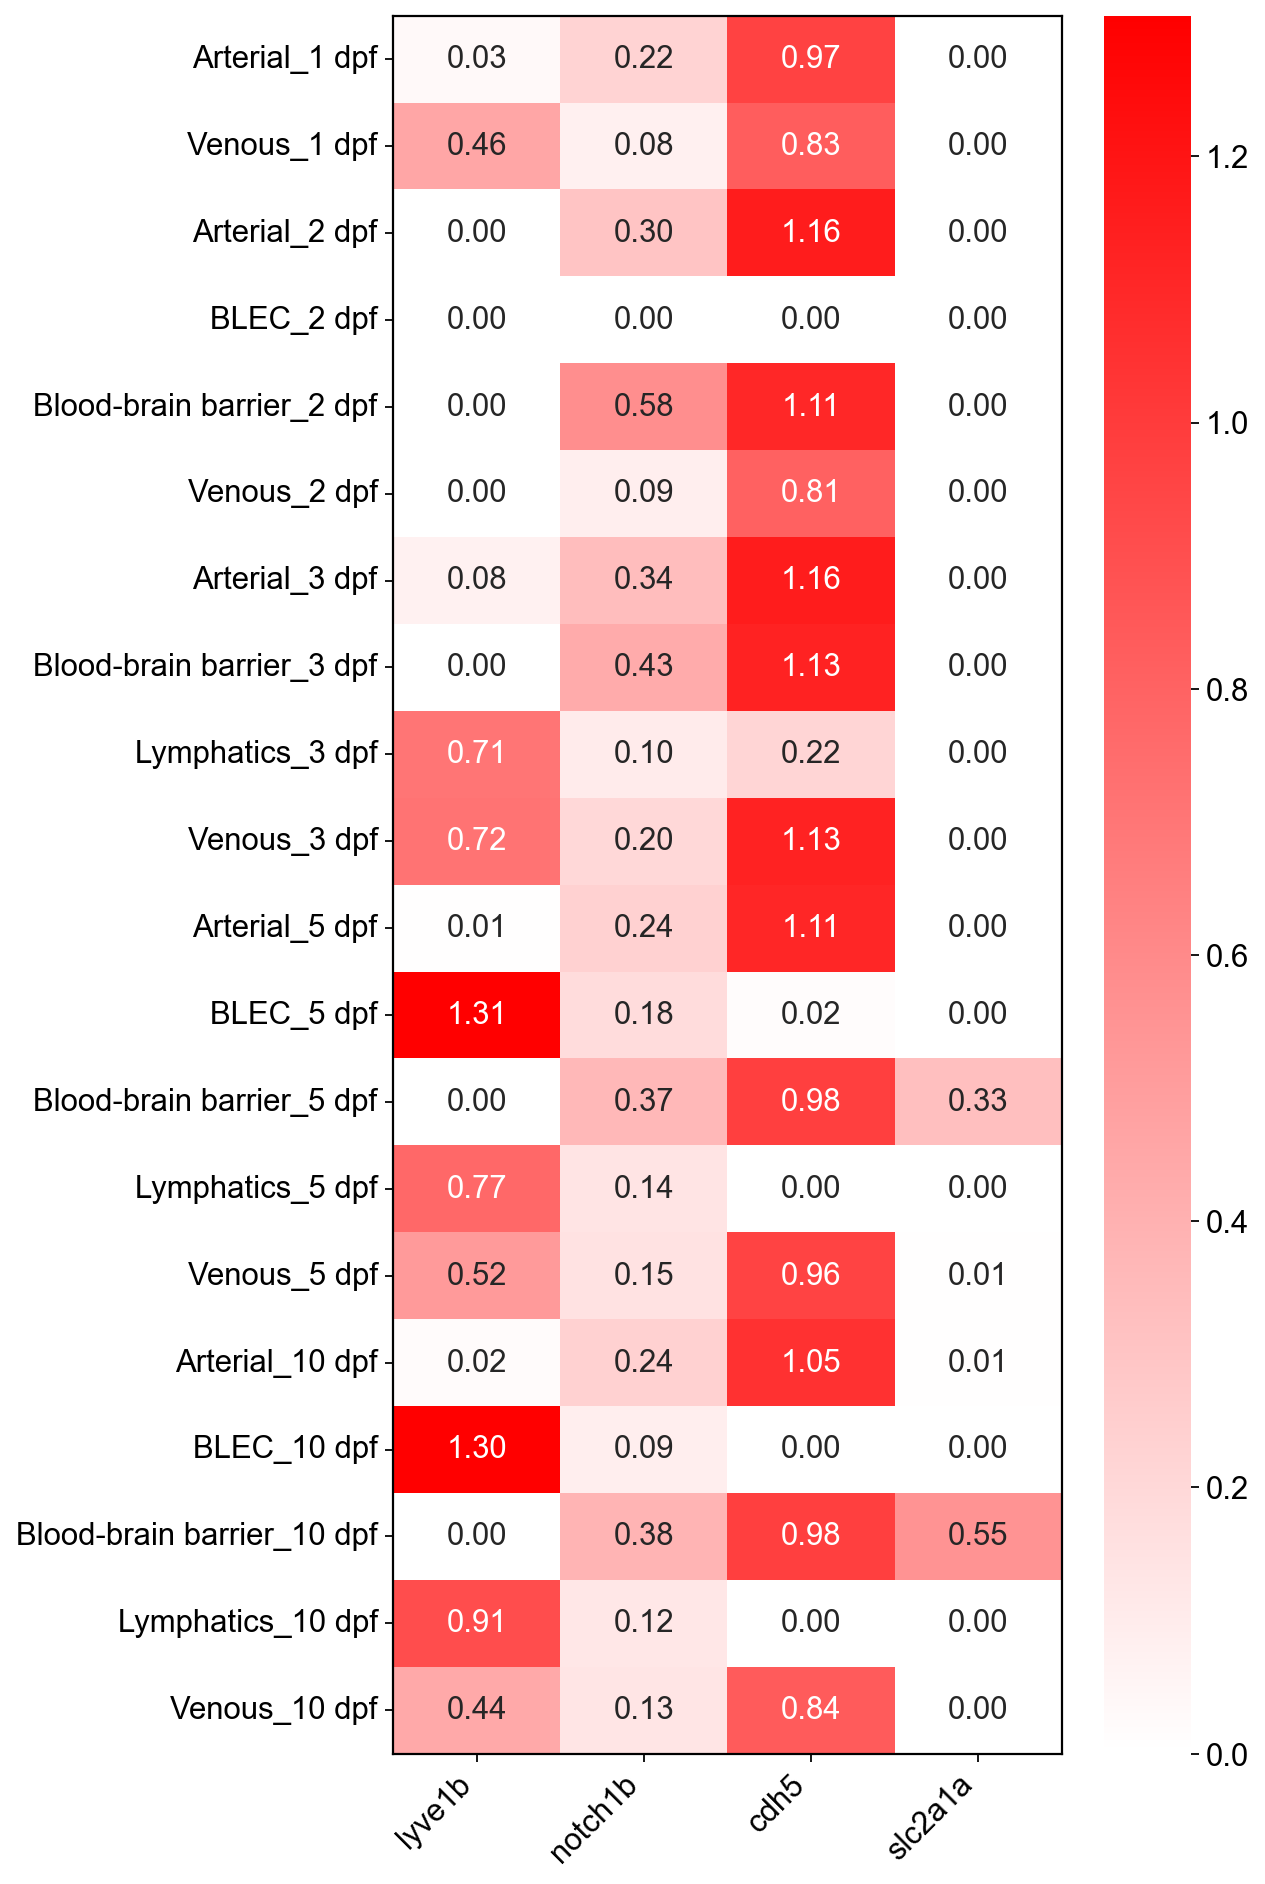

In [35]:
# Seaborn heatmap expression plot
# For additional information please refer to:
    # https://seaborn.pydata.org/generated/seaborn.heatmap.html

plt.figure(figsize=(8,12))
ax = sns.heatmap(df_means, # Dataframe containing the mean expression of each gene
                 annot=True, # Print mean values
                 fmt=".2f", # Use two decimals for mean values
                 cmap=cmap2, # Define the colormap
                 )

for _, spine in ax.spines.items():
    spine.set_visible(True)  # Make spines visible
    spine.set_color('black')  # Set frame color to black
    spine.set_linewidth(1)  # Set frame thickness

ax.set_ylabel('')
ax.grid(False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()  # Adjust layout for better appearance
plt.show()

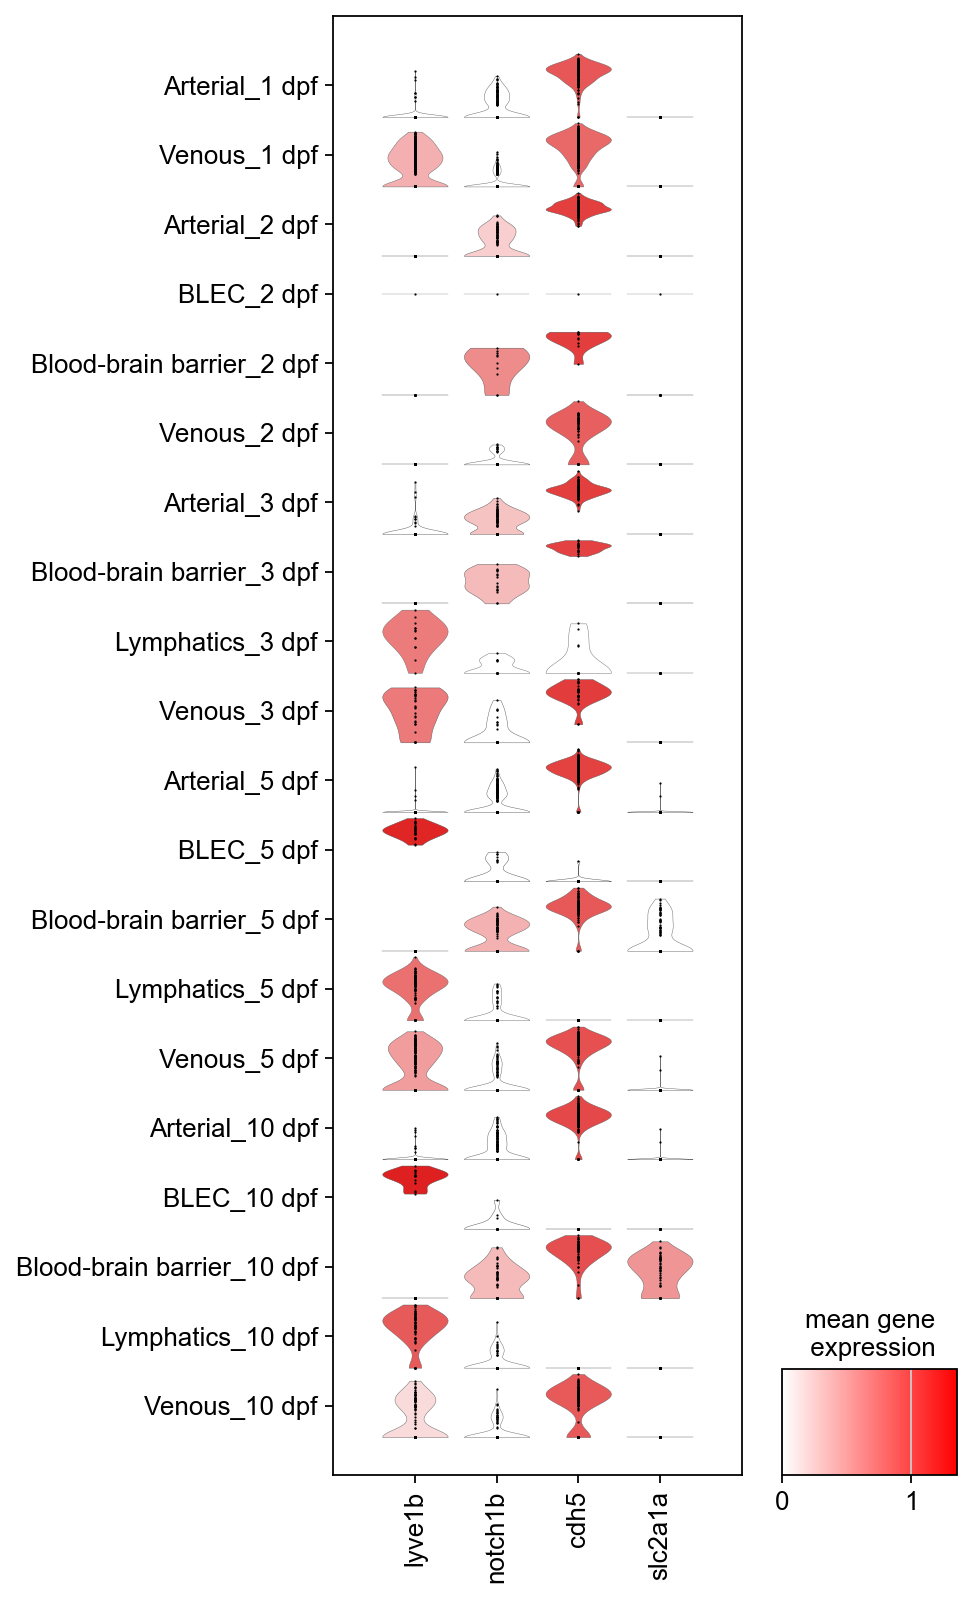

In [36]:
# Scanpy stacked violin plot function: Makes a compact image composed of individual violin plots stacked on top of each other. Useful to visualize gene expression per cluster.
# For additional information please refer to:
    # https://scanpy.readthedocs.io/en/stable/generated/scanpy.pl.stacked_violin.html
    # https://seaborn.pydata.org/generated/seaborn.violinplot.html#seaborn.violinplot

sc.pl.stacked_violin(bdata, 
                     genes, # Define the list of genes to plot
                     groupby='celltype_Dev_stage', # Label in bdata.obs to group
                     categories_order = order, # Define a specific order for the labels
                     use_raw= True, # Use the original raw expression values stored in bdata
                     stripplot = True, # Include individual datapoints inside the violin plot                   
                     cmap = cmap2, # Define the colormap
                     figsize=(5,12), # Determine the size of the final figure
                     dendrogram=False,# Remove the dendogram to have clusters ordered as defined in categories_order
                     colorbar_title = 'mean gene\n expression', # Define the title of the colorbar
                     )

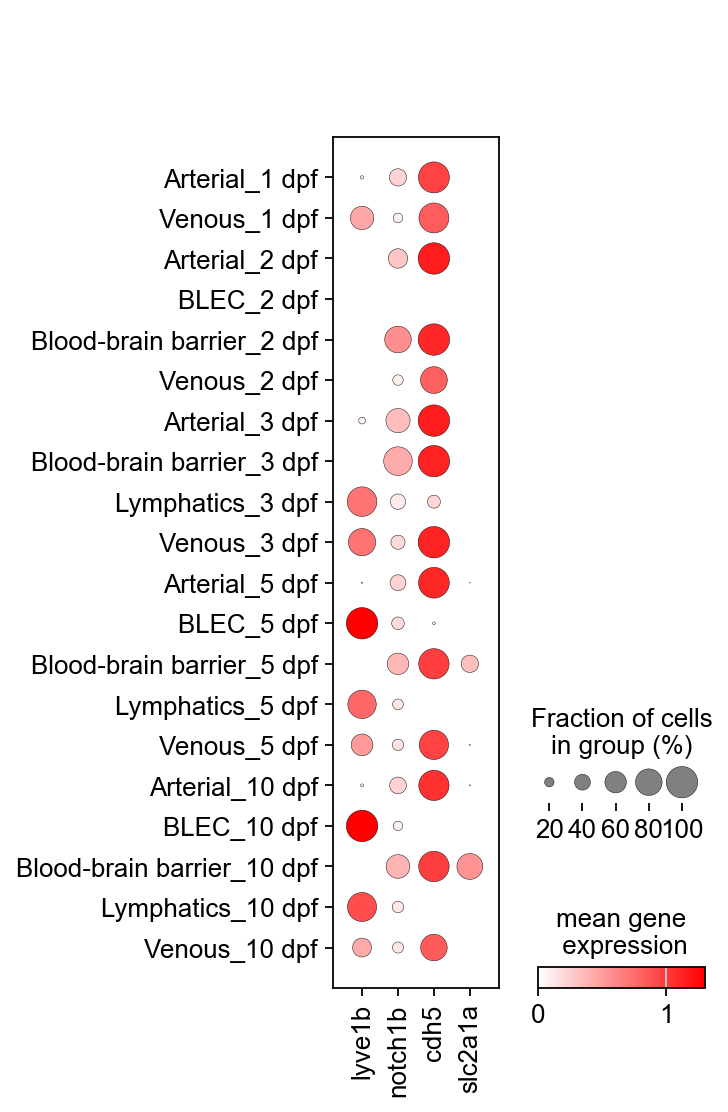

In [37]:
sc.pl.dotplot(bdata, 
              genes, # Define the list of genes to plot
              groupby='celltype_Dev_stage', # Label in bdata.obs to group
              use_raw= True, # Use the original raw expression values stored in bdata
              mean_only_expressed = False, # Account for the expression of all cells within the cluster
              categories_order = order, # Define a specific order for the labels
              smallest_dot = 0, # Define the size of the smallest dot. Setting this to '0' will allow to identify cells not expressing the gene of interest.
              cmap = cmap2, # Define the colormap
              colorbar_title = 'mean gene\n expression', # Define the title of the colorbar
              )

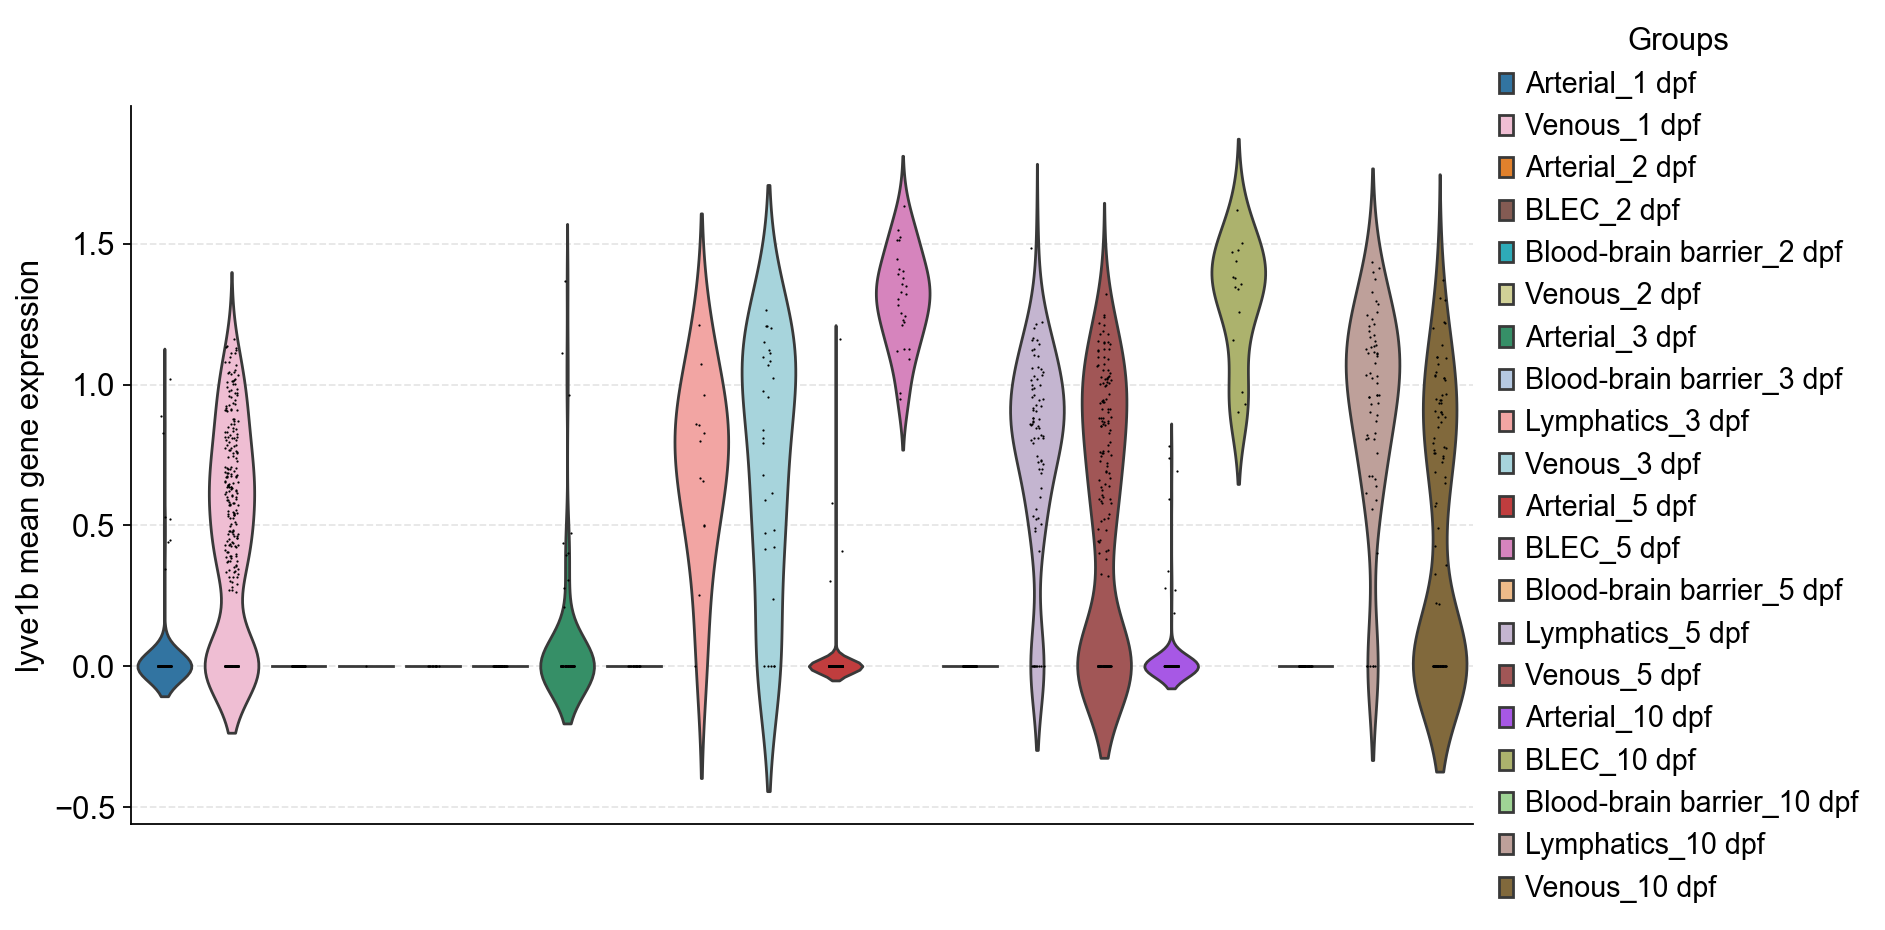

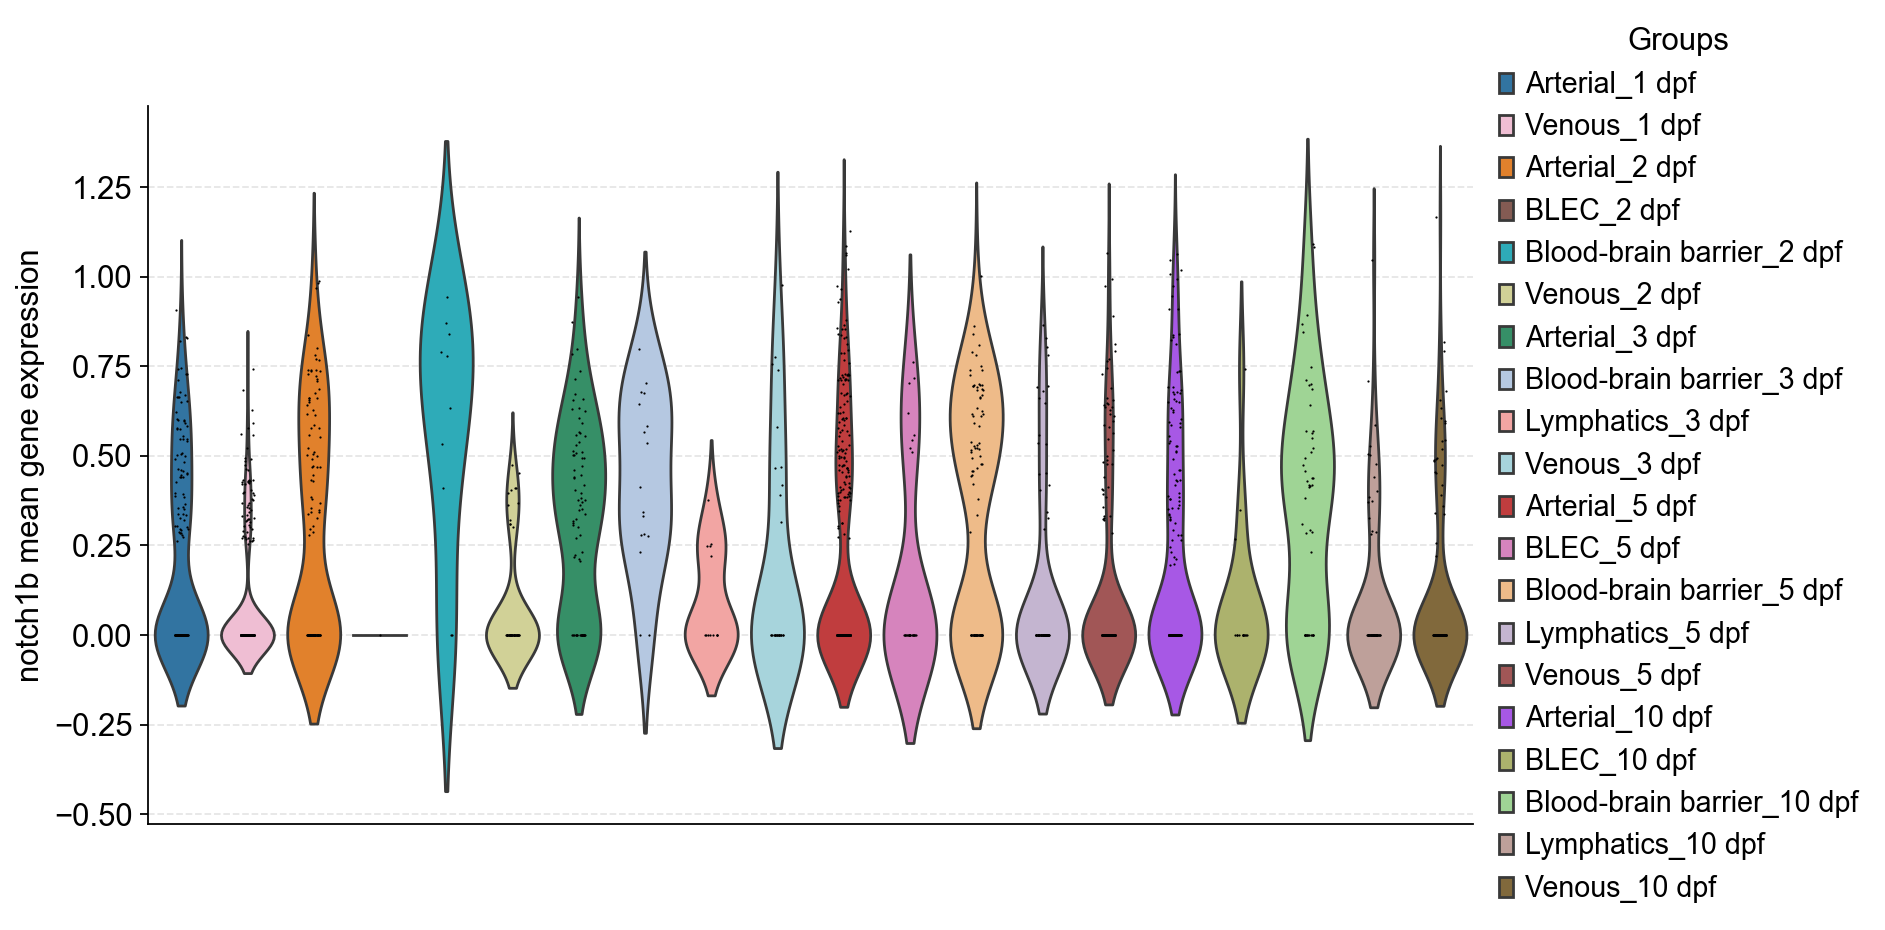

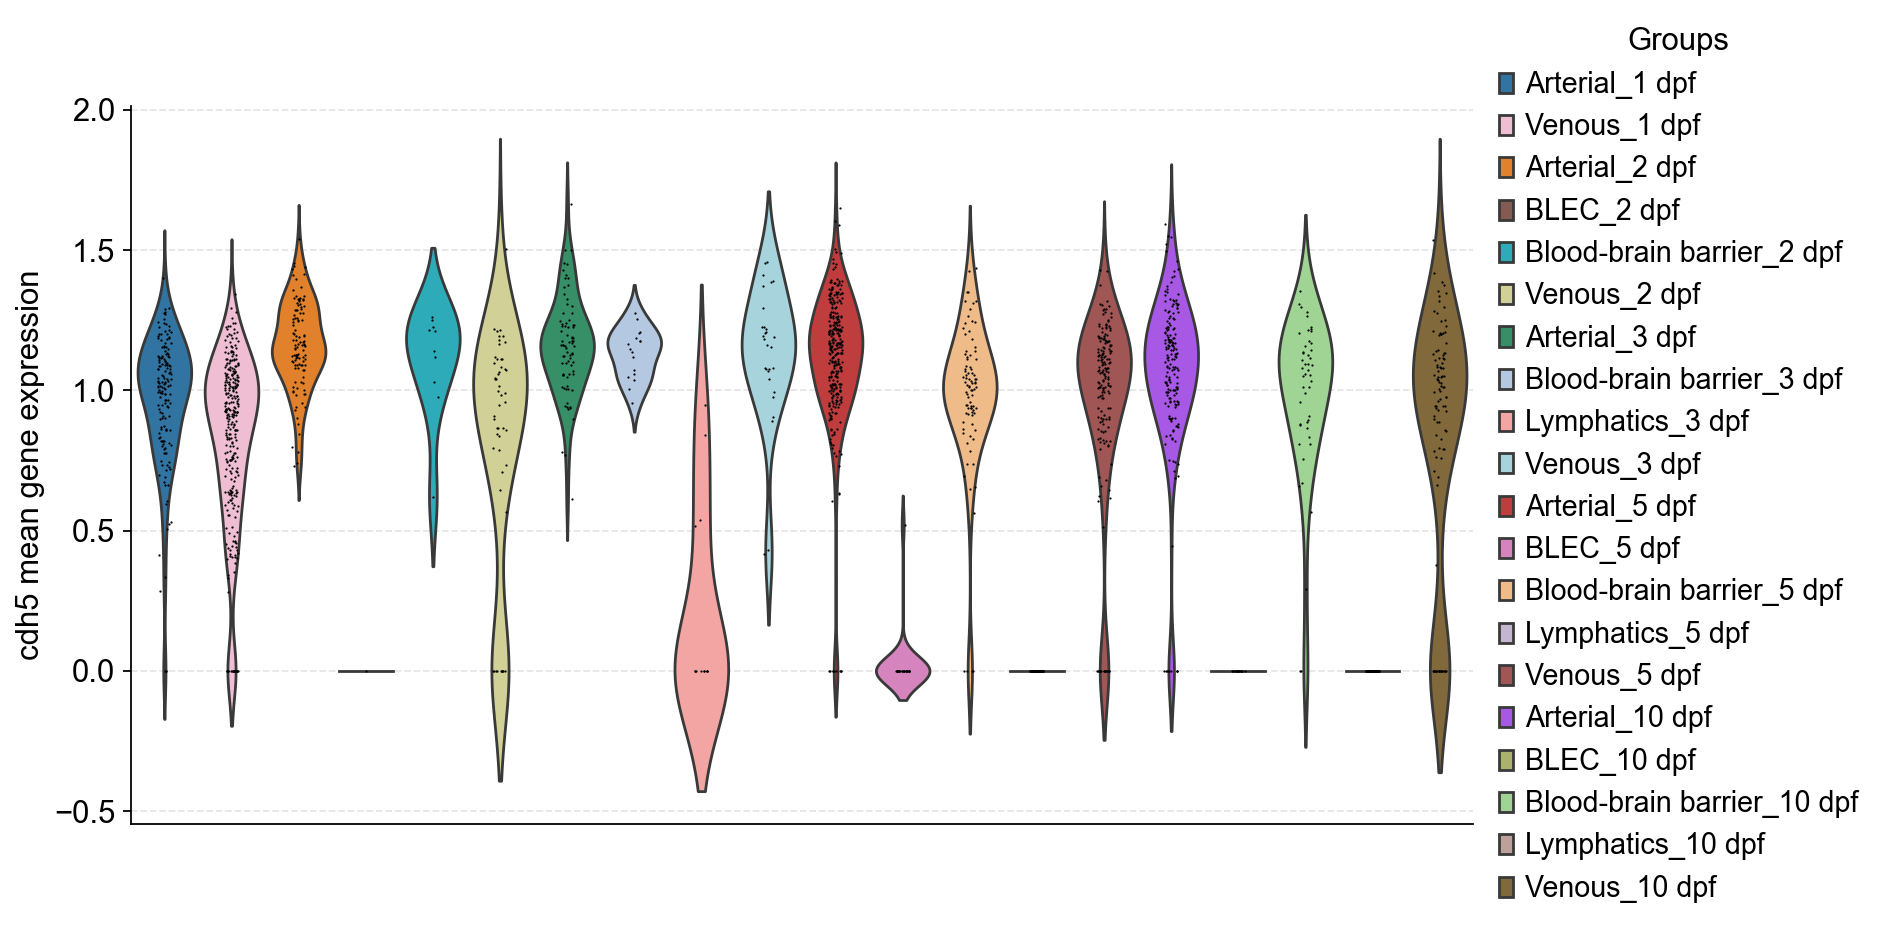

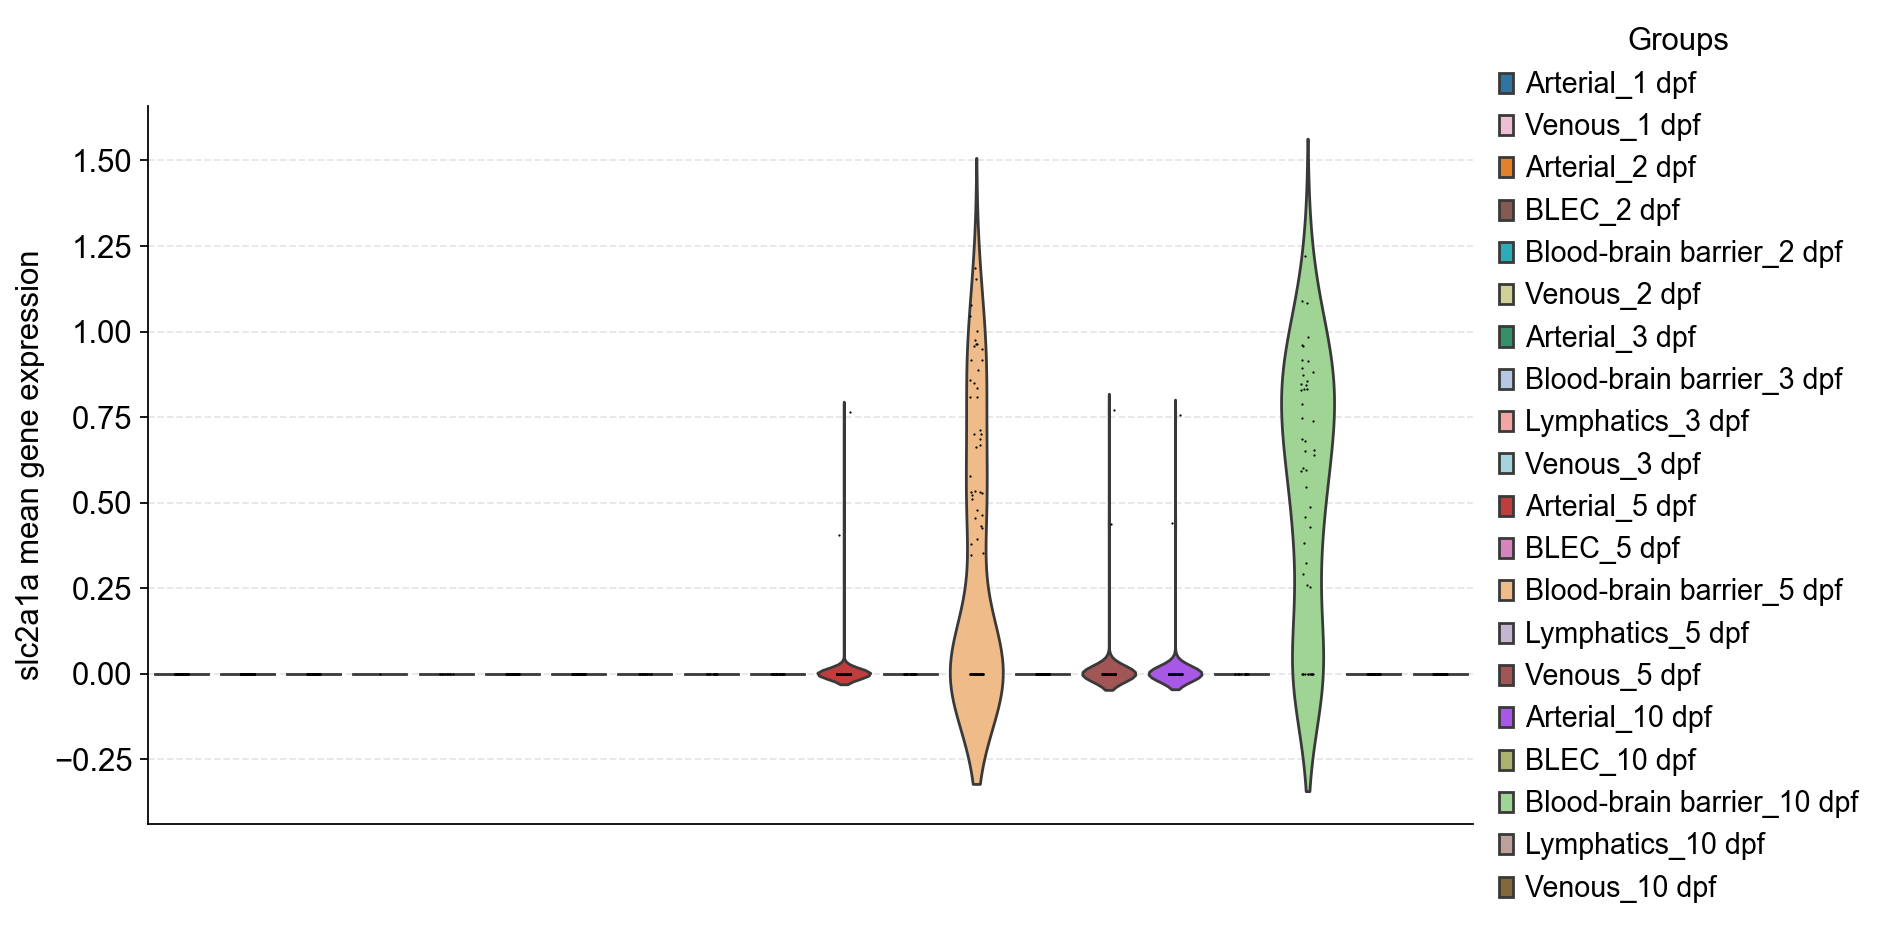

In [38]:
# Generates individual violin plots for each gene of interest

for key in genes: # Loop for each key stored in the list of genes
        fig = plt.figure(figsize=(12, 6)) # Define the size of each plot
        ax = fig.add_subplot()
        ax = sc.pl.violin(bdata, 
                          keys=key, # Define the gene to plot
                          groupby='celltype_Dev_stage', # Label in bdata.obs to group
                          order = order, # Define a specific order for the labels
                          use_raw= True, # Use the original raw expression values stored in bdata
                          stripplot = True, # Include individual datapoints inside the violin plot 
                          show = False, # Set to False to allow the for loop to finish eah plot
                          ax = ax, # Retrieve the axis information
                          legend = 'brief', # Reduce legend
                          hue_order = order, # Define a specific order for the labels within the legend
                          cut=2.0, # Modify the length of the violin frames. This is set for visualisation purposes
                          )
        
        ax.set_axisbelow(True)  # Make gridlines appear behind all plots
        ax.yaxis.grid(True, linestyle='--', alpha=0.5) # Define dashed horizontal lines for each Y axis value value
        ax.set_xlabel('') # Remove X axis title
        ax.set_xticks([])  # Remove X axis ticks
        ax.set_xticklabels([]) # Remove X axis labels
        ax.spines['top'].set_visible(False) # Remove top frame line
        ax.spines['right'].set_visible(False) # Remove right frame line
        handles, _ = ax.get_legend_handles_labels() # Retrieve the handles from the legend information
        ax.set_ylabel(f'{key} mean gene expression') # Change Y axis title
        
        ax.legend(title='Groups', # Define the legend title
                  loc='center left', # Define overall the position for the legend
                  bbox_to_anchor=(1, 0.5), # Define coordinates to anchor the legend
                  frameon=False # Remove legend frame
                )
        
        plt.tight_layout()
        plt.show()

# <a id='toc5_'></a>[Data visualisation 2 - Percentage of cells expressing the gene of interest](#toc0_)

In [39]:
def columnplot(gene_box_plot, bdata):
    dfss = []
    for i in bdata.obs['celltype_Dev_stage'].unique(): # Change to the bdata.obs variable to be grouped by; for example: 'cluster_labels'
        subset = bdata[bdata.obs['celltype_Dev_stage'] == i] # Subset bdata based on the previous defined category
        exp = pd.DataFrame(subset[:,gene_box_plot].X.todense()) # Obtain the raw counts for each gene of interest
        exp.rename(columns={0: i}, inplace=True)
        null_count = (exp == 0).sum().sum() # Obtain the number of cells not expressing the gene of interest
        expressing_cells = (exp.shape[0] - null_count) * 100 / exp.shape[0] # Calculate the percentage of cells expressing the gene of interest
        data = [{i:exp.shape[0]},
                {i:null_count},
                {i:expressing_cells},
                {i:100-expressing_cells}
                ]
        dfaa = pd.DataFrame(data, index=['total_cells', 'null_cells', 'perc_expressing', 'perc_notexpressing']) # Create a dataframe for each 'celltype_Dev_stage'
        dfss.append(dfaa)
        
    combined_dfss = pd.concat(dfss, axis=1).T # Combine all the previous dataframes
    combined_dfss['Column_name'] = combined_dfss.index
    combined_dfss['Stage'] = combined_dfss['Column_name'].apply(
        lambda x: re.search(r'\d+ dpf', x).group() if re.search(r'\d+ dpf', x) else None
    ) # Retrieve the zebrafish embryo developmental stage for each 'celltype_Dev_stage'
    stage_order = ['1 dpf', '2 dpf', '3 dpf', '5 dpf', '10 dpf'] # Define the order for the plot of the zebrafish embryo developmental stage
    stage_type = CategoricalDtype(categories=stage_order, ordered=True) 
    combined_dfss['Stage'] = combined_dfss['Stage'].astype(stage_type) # Transform the developmental stages into categorical variables
    combined_dfss.sort_values(['Stage', 'Column_name'], ascending=[True, True], inplace = True)
    combined_dfss.drop(['Stage', 'Column_name'], axis=1, inplace=True) # Sort the dataframe
    dfplot = combined_dfss.drop(columns=['total_cells', 'null_cells'], axis = 1) # Delete the columns containing the total number of cells and the number of cells not expressing the gene of interest
    
    return dfplot, combined_dfss 
    

In [40]:
gene_box_plot = 'lyve1b' # Define the gene of interest to plot
dfplot = columnplot(gene_box_plot, bdata) # Run the previous function to retrieve cell percentages

/var/folders/_q/6ptq9jv957j7n55rqly2cpf80000gn/T/ipykernel_43107/1883343845.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_cells = dfplot[1]["total_cells"][i].astype(int)


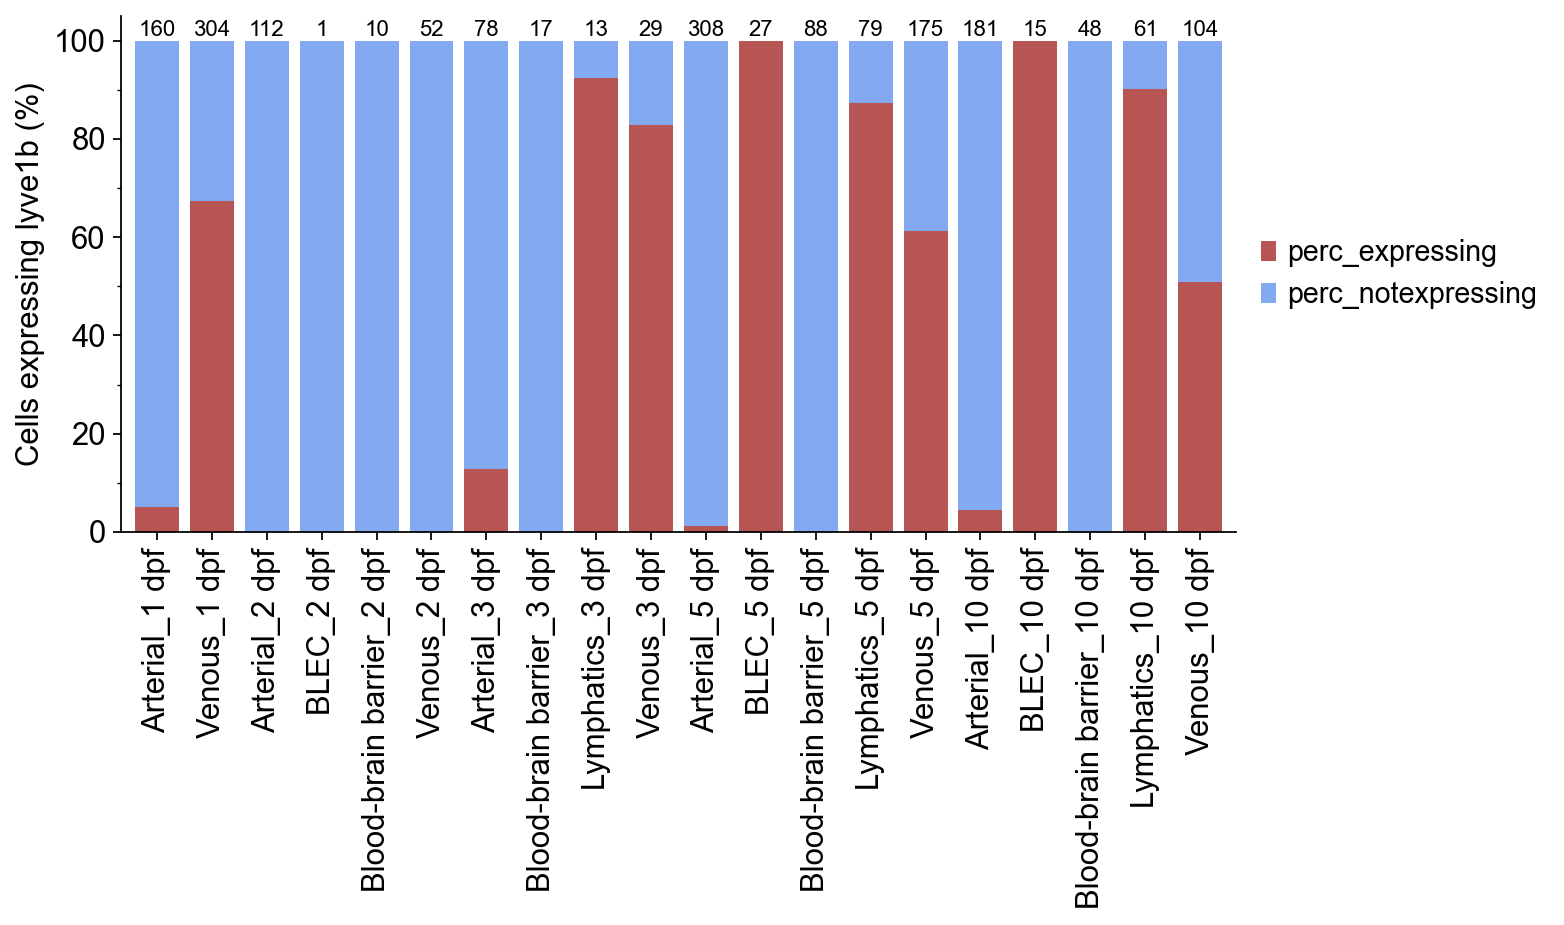

In [41]:
# Stacked barplots with the percentage of cells expressing the gene of interest

ax = dfplot[0].plot(kind='bar', # Define the type of plot
                    stacked=True, # Use to plot stacked bars
                    color=['brown', 'cornflowerblue'], # Define the colours for each category
                    alpha=0.8, # Define the opacity
                    figsize=(10, 6), # Define the size of the figure
                    width=0.8, # Define the width for each stacked bar
                    )

ax.set_ylabel(f'Cells expressing {gene_box_plot} (%)') # Rename the title of the Y axis
ax.grid(False) # Remove the internal grid
ax.spines['top'].set_visible(False) # Remove top frame line
ax.spines['right'].set_visible(False) # Remove right frame line
ax.yaxis.set_minor_locator(MultipleLocator(10)) # Add internal ticks to Y axis

plt.legend(loc='center left', # Define overall the position for the legend
           bbox_to_anchor=(1, 0.5), # Define coordinates to anchor the legend
           frameon=False # Remove legend frame
           )

# Print the total number of cells on top of each stacked barplot
for i, idx in enumerate(dfplot[0].index):  # Iterate over rows (categories)
    total_cells = dfplot[1]["total_cells"][i].astype(int)
    cumulative_height = 0  # Track the cumulative height of stacked bars
    for j, col in enumerate(dfplot[0].columns):  # Iterate over columns (stacked segments)
        cumulative_height += dfplot[0].iloc[i, j]  # Add the current bar's height
    ax.text(
        i, cumulative_height + 1,  # Position: x = category index, y = top of the stack
        str(total_cells),          # Text: total cells
        ha='center', size=10
    )

plt.tight_layout()
plt.show()